## IP Project Group 3: Price Prediction on Uniplaces.com

### [0] Notes on the use of this code:
- Some packages used might not be included in the default python library packages and need to be downloaded and installed. 

- The uniplaces webscraper from step [1] will return different results every time it is run. 
- API calls for geopy zip code scraping [2] are limited for certain time periods, meaning the code had to be run over several days.
- The Google Maps scraping [4] was conducted using a personal Google API key. Since this key is connected to a personal billing account, the key was removed from the code. A key can be obtained here:
https://developers.google.com/maps/documentation/javascript/get-api-key

Based on these facts, we created CSV files with iterim results throughout our project in order to work with a uniform dataset. Thus, scrapers included in this code do not need to run again but we access the content of the CSV files for different steps of the project, instead. Please specify the correct CSV file locations in project steps [2], [3] and [4].

The following CSV files are used:
- Scraped_data_2311.csv: The full data frame of information scraped from uniplaces in step [1].
- Scraped_zipcodes.csv: The corresponding zip codes for the scraped data, scraped using Geopy in step [2].
- Scraped_geolocations.csv: Geolocations of subway stations, universities and tourist attractions scraped in [4].

The mentioned scrapers were commented for a smooth run of the full code.
- The uniplaces webscraper [1] can be uncommented and run, but will produce different results.
- The geopy zip code scraper [2] can be uncommented and run with a subset of the data frame. Else, it will time-out.
- The Google Maps scraper [4] can be uncommented and run if a valid Google Maps API key is inserted.


### [1] Webscraper
For each Lisbon listing, we scraped the relevant details of the offer from https://www.uniplaces.com/.

In [1]:
# Import relevant packages
import requests
import pandas as pd
from pandas.io.json import json_normalize

In [2]:
# Create empty lists and data frames for the data
url = []
properties =[]
offers = []
units = []
titles = []
metadata = pd.DataFrame()
df = pd.DataFrame()

In [3]:
# Request the json response from the Uniplaces API:
# Loop over all pages on Uniplaces with the specific geolocation parameters of Lisbon and specify language is English. 
for i in range(1,140):
    resp = requests.get(
        url = 'https://www.uniplaces.com/api/search/offers', 
        params = {
            "city":'PT-lisbon',
            "limit":'24',
            "locale":'en_GB',
            "ne":'38.804935133335775%2C-9.076080322265625',
            "page":i,
            "sw":'38.67880960144873%2C-9.295806884765625',
               
        })
# Save the json response in a variable
    body = resp.json()
# From the json response, extract the property id, offer id, title of the offer and the rental type to the pre-defined variables
    for t in body['data']:
        properties.append(t['attributes']['property']['id'])
        offers.append(t['id'])
        units.append(t['attributes']['property']['rent_by'])
        titles.append(t['attributes']['accommodation_offer']['title'])
        url.append(t['id'])

In [4]:
# Check the length of the scraped offer_ids
len(url)

2804

In [5]:
# Check the length without duplicates
len(set(url))

2751

In [6]:
# Convert the lists to columns in the ‘metadata’ dataframe
metadata['offer_id'] = offers      
metadata['units'] = units
metadata['title'] = titles
metadata['offer_id'] = metadata['offer_id'].astype(int)

In [7]:
# Observe metadata data frame
metadata.head()

,offer_id,units,title
0,140033,unit,Bright an modern ensuite room in Parede close ...
1,140036,unit,Appealing ensuite bedroom in Parede close to N...
2,170795,unit,"Double bedroom in Baixa, near Baixa-Chiado met..."
3,17755,unit,Really bright single bedroom in a big apartmen...
4,156599,unit,Double bedroom in 5-bedroom apartment


In [8]:
# The GraphQL introspection query allows us to understand the field structure of the Uniplaces GraphQL API in order to query the relevant fields later on
query = """
 query IntrospectionQuery {
    __schema {
      queryType { name }
      types {
        ...FullType
      }
      directives {
        name
      }
    }
  }

  fragment FullType on __Type {
    name
    fields(includeDeprecated: false) {
      name

    }
    inputFields {
      ...InputValue
    }
  }

  fragment InputValue on __InputValue {
    name
  }

"""
# Specify the website to post the request to (Uniplaces GraphQL API)
resp = requests.post(
    'https://offer-aggregate-graphql.uniplaces.com/graphql', 
    json= {
        "query": query}
)

# Save the json response in a variable and print the result
body = resp.json()
print(body)

{'data': {'__schema': {'queryType': {'name': 'Query'}, 'types': [{'name': 'Query', 'fields': [{'name': 'offerAggregate'}], 'inputFields': None}, {'name': 'ID', 'fields': None, 'inputFields': None}, {'name': 'Boolean', 'fields': None, 'inputFields': None}, {'name': 'OfferAggregate', 'fields': [{'name': 'id'}, {'name': 'accommodation_offer'}, {'name': 'accommodation_provider'}, {'name': 'property_aggregate'}, {'name': 'photos'}, {'name': 'search_photos'}, {'name': 'units_sorted'}, {'name': 'globalization_aggregate'}, {'name': 'created_at'}], 'inputFields': None}, {'name': 'AccommodationOffer', 'fields': [{'name': 'id'}, {'name': 'parent'}, {'name': 'version'}, {'name': 'accommodation_provider_id'}, {'name': 'availability_summary_info'}, {'name': 'availabilities'}, {'name': 'property'}, {'name': 'title'}, {'name': 'requisites'}, {'name': 'costs'}, {'name': 'contract'}, {'name': 'restrictions'}, {'name': 'main_photo'}, {'name': 'floor_plan'}, {'name': 'reference_price'}, {'name': 'lifecycl

In [9]:
# # For each URL (individual page): query the listing specifications via a GraphQL query from the Uniplaces GraphQL API   
# # We use the set or our previously saved unique offer_ids (url) in order to loop over all offers. 
# # We did this because we were not entirely sure how the scraper would behave when we entered a larger page number that actually exists but we wanted to be sure that we only have information about each listing once.
# for i in ((set(url))):
#     # Print offer id at the beginning of each query - if anything goes wrong we can check this specific listing for the root-cause
#     print(i)
# # Define data frames to hold the scraped data
#     df_kitchen = pd.DataFrame()
#     df_bathroom = pd.DataFrame() 
#     df_rules = pd.DataFrame() 
#     df_bedroom = pd.DataFrame() 
#     df_living_room = pd.DataFrame()
# # For each offer_id, query the fields below from the GraphQL API
# # Fields were chosen looking at the result of the introspection query. We wanted to choose all the fields that are shown on the Uniplaces listing site.
#     id = i
#     query = """
#         query($id: ID!) { 
#             offerAggregate(id: $id) { 
#                 accommodation_offer {
#                         id
#                     contract {
#                             type
#                             exclusive
#                             is_instant_booking
#                             commission
#                             deposit{
#                                 pay_to
#                                 type
#                                 value{
#                                         amount
#                                         currency_code}
#                     }
#                             admin_fee {
#                             exact_value
#                             value {
#                                     amount
#                                     currency_code}}
#                           fixed_unitary
#                           {
#                             extra_per_guest
#                             {
#                                   amount
#                                   currency_code}
#                           }
                    
#                     }
#                     reference_price {
#                         amount
#                         currency_code
#                     }
#                     requisites {
#                         conditions {
#                             cancellation_policy
#                             minimum_nights
#                             max_guests
#                         }
#                     }
#                     costs {
#                             bills {
#                                     water {
#                                             included
#                                             }
#                                     electricity {
#                                             included
#                                             }
#                                     gas {
#                                             included
#                                             }
#                                     internet {
#                                             included
#                                             }
#                                     }
#                             services {
#                                     cleaning
#                                     {
#                                             periodicity
#                                             }
#                                     }
#                     }
#                 }
#                 accommodation_provider
#                 {
#                 stats{
#                         bookings{
#                                 accepted{
#                                         total}
#                                 requested{
#                                         total}
#                                 rejected{
#                                         total}
#                                 confirmed{
#                                         total}}}
#                 created{
#                         at
#                                 }
                
                
#                 }
#                 id
#                 units_sorted{unit_id
#                 __typename}
#                 property_aggregate {
#                     property {
#                         id
#                         landlord_resident {
#                                 gender
#                                 age_range
#                                 occupation
#                         }
            
#                         floors {
#                                 units {
#                                         id
#                                         type_code
#                                         features{Code Exists}
#                                         subunits{id
#                                         type_code
#                                         features
#                                         {Code
#                                         Exists
#                                         }}
#                         }
#                         }
#                         rules {
#                                 code
#                                 exists
#                         }
#                         typology {
#                             area
#                             accommodation_type_code
#                             type_code
#                             number_of_bedrooms
#                             number_of_bathrooms
#                         }
#                         location {
#                                 neighborhood_id
#                                 geo{
#                                     latitude
#                                     longitude
#                                     }
#                         address {
#                                 postal_code
                                
#                                 }
#                         }
#                         verification {
#                         verified}
                    
#                     }
#                         neighborhood{id
#                         city_code
#                         slug
#                         }
#                 }
                
#             } 
#         }
#     """
    
#     resp = requests.post(
#         'https://offer-aggregate-graphql.uniplaces.com/graphql', 
#         json={
#             "query": query,
#             "variables": {
#                 "id": id
#             }
#         }
#     )
# # Save the json response into a variable
#     json = resp.json()
#     json

#  # Save the normalized json response into a pandas dataframe
#     i = pd.DataFrame.from_dict(json_normalize(resp.json()), orient='columns')
    
    
#  # After normalizing the json response, some columns still contain lists of dictionaries that we couldn’t unwind using json_normalize
# # We accessed the lists and assigned the variables to dataframe columns
# # Bedroom: in cases where the bedroom unit_id matches the first unit in the units_sorted list: we can assign this bedroom as the bedroom of this listing
# # else, bedroom information is not given or it is unclear which bedroom the listing is referring to
#     units = json['data']['offerAggregate']['property_aggregate']['property']['floors'][0]['units']
#     for u in units:
#         if u['type_code'] == 'bedroom' and u['id']==json['data']['offerAggregate']['units_sorted'][0]['unit_id'] :
#             bedroom_dict = u
#             break
#         else:
#             bedroom_dict = {}
    
                
# # Since there can be several bathrooms in a flat  it is hard to assign specific features to the ‘bedroom’ (e.g. windows) 
# # We decided that the only variable that really was important to us is whether there is a bathtub in the flat. 
# # We can safely assume that a toilet, sink etc. exists in each flat so we will not check these variables independently
# # Each property can have several bathrooms, so we loop through the units and check whether it is a bathroom. If so, we check for the ‘bathtub’ feature
#     bathroom_dict = {}             
#     for u in units:
#         if u['type_code'] == 'bathroom':
#             bathr=u
#             if bathr['features'] is not None:
#                 for item in bathr['features']:
#                     if item['Code'] == 'bathtub' and item['Exists'] == True:
#                         bathroom_dict['bathroom_bathtub'] =  True
                                   

# # Create a dictionary for each room type if this room type is specified in the offer  in order to save its features 
# # Create dictionary for living-room     
#     for u in units: 
#         if u['type_code'] == 'living-room':
#             living_room_dict = u
#             break
#         else:
#             living_room_dict= {}

# #Create a dictionary for kitchen            
#     for u in units: 
#         if u['type_code'] == 'kitchen':
#             kitchen_dict = u
#             break
#         else:
#             kitchen_dict= {}

# # Normalize the kitchen feature information into the kitchen_dict
#     if kitchen_dict: 
#         if kitchen_dict['features'] is not None:
#             df_kitchen = json_normalize({('kitchen_' + item['Code']):item['Exists'] for item in kitchen_dict['features']})
    
# # Normalize the bedroom feature information into the bedroom_dict        
#     if bedroom_dict:
        
#         if bedroom_dict['features'] is not None: 
#             df_bedroom = json_normalize({('bedroom_' + item['Code']):item['Exists'] for item in bedroom_dict['features']})

# # The bed-type of the bedroom is specified as a subunit
# # In order to extract this information we check whether the subunit is     
#         if bedroom_dict['subunits'] is not None:
#             bedr = bedroom_dict['subunits']
#             list_sb = []
#             for u in bedr:
#                 if u['type_code'] == 'single-bed':
#                     list_sb.append(u)
#             df_bedroom['single_beds'] = len(list_sb)
#             list_db = []
#             for u in bedr:
#                 if u['type_code'] == 'double-bed':
#                     list_db.append(u)
#             df_bedroom['double_beds'] = len(list_db)
    
#             bathr = bedroom_dict['subunits']
#             for u in bathr:
#                 if u['type_code'] == 'bathroom':
#                     df_bedroom['private_bathroom'] = True
#                     break
            
#     if bathroom_dict:
#             for item in bathroom_dict:
#                 df_bathroom = pd.DataFrame([bathroom_dict])
                
                
#     # Save features of the living_room 
#     if living_room_dict: 
#         if living_room_dict['features'] is not None:
#             df_living_room = json_normalize({('living_room_' + item['Code']):item['Exists'] for item in living_room_dict['features']})

#    # Unwind the list of dictionaries containing the property rules
#     if json['data']['offerAggregate']['property_aggregate']['property']['rules'] is not None:
#         rules_dict = json['data']['offerAggregate']['property_aggregate']['property']['rules']
#         df_rules = json_normalize({(item['code']):item['exists'] for item in rules_dict})
#     else:
#         rules_dict = {'pets-allowed':False,'smoking-allowed':False,'overnight-guests-allowed':False}
#         df_rules = pd.DataFrame(rules_dict, columns = ['pets-allowed','smoking-allowed','overnight-guests-allowed'], index=[0] )

# # Create a combined data frame for all room features for the specific listing
#     df_result = pd.concat([i,df_kitchen, df_bathroom, df_rules, df_bedroom, df_living_room],axis=1)

# # Append the room features to the universal data frame as a new row
#     df = df.append(df_result, sort=False)

# # Convert both offer_id's in ‘df’ and ‘metadata’ to integers to be able to merge
# df['data.offerAggregate.id']=df['data.offerAggregate.id'].astype(int)
# metadata['offer_id']=metadata['offer_id'].astype(int)

# # Merge the data frames for full information on the listings
# df = df.merge(metadata,how='left',left_on='data.offerAggregate.id', right_on='offer_id')

The results were saved as Scraped_Data_2311.csv

In [10]:
# df.to_csv('Scraped_data_2311.csv')

### [2] Geopy zip-code scraping
In order to filter for only Lisbon housing offers, we scraped all zip codes based on the geolocation of the uniplaces listings.

Since allowed API calls are limited, the scraper was run over several days. We saved the results as 'Scraped_Zipcodes.csv', which we access in the following. The Geopy scraper is commented, so the full code can run smoothly. However, the scraper can be uncommented and tested with a subset of the dataframe.

In [11]:
# Import Relevant packages
from geopy.geocoders import Nominatim
import re
from geopy.exc import GeocoderTimedOut

In [12]:
# Import scraped file (PATH NEEDS TO BE INSERTED)
df = pd.read_csv('Scraped_data_2311.csv')

In [13]:
# Rename the relevant columns: longitude and latitude
df = df.rename(columns={'data.offerAggregate.property_aggregate.property.location.geo.latitude': 'latitude', 'data.offerAggregate.property_aggregate.property.location.geo.longitude': 'longitude'})

In [14]:
# ## Scrape zip codes ###
# #Create a list that will be used inside the for loop to append zip codes
# list_ZipCodes = []

# #Initialize the variable i so we know what iteration of the loop we are at
# i = 0

# #Create a Nominatim object called geolocator
# geolocator = Nominatim(user_agent="IP Project")

# #Loop through the dataframe
# for index, row in df.iterrows():
#     if(i in range(0, 2938)):
#         #Store the latitude and longitude into variables
#         latitude_var = row['latitude']
#         logitude_var = row['longitude']
#         #Create a string that will be passed into the geolocator.reverse() function
#         created_string = '"'+str(latitude_var)+', '+str(logitude_var)+'"'
#         #Try to obtain the full address and then extract the zipcode from that address
#         try:
#             location = geolocator.reverse(created_string)
#             toAppend = str(re.findall('[0-9][0-9][0-9][0-9][\-][0-9][0-9][0-9]', str(location)))
#         #Sometimes an exception is raised because the geolocator.reverse() times out and
#         #sometimes the regex findall() method cannot extract the zipcode
#         except:
#             #Set the to Append variable "[]". I chose this string because sometimes the above regex will set toAppend
#             #to "[]" without entering the exception block, so this will keep things consistent
#             toAppend = "[]"
#         #Append the toAppend variable to the list of zipcodes
#         list_ZipCodes.append(toAppend)
#         #Increment iterator
#         i+=1
#         #If i was in the range then continue with the loop
#         continue
#     #Else i was not in the range so break out of the loop
#     else:
#         break    

# #Create a new dataframe from the list of zipcodes
# df_zips = pd.DataFrame(list_ZipCodes, columns=['ZipCode'])

# #Remove the brackets that are in each string
# df_zips['ZipCode'] = df_zips['ZipCode'].str.strip('[]')

# #Remove the single quotes that are in each string
# df_zips = df_zips.applymap(lambda x: x.replace("'", ""))

The results were saved as Scraped_Zipcodes.csv

In [15]:
# df.to_csv('Scraped_zipcodes.csv')

### [3] Data Cleaning

In [16]:
# Import required packages
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np

In [17]:
#Importing required files
# The scraped data frame (THE PATH NEEDS TO BE INSERTED)
df = pd.read_csv('Scraped_data_2311.csv')

# The scraped zip codes (THE PATH NEEDS TO BE INSERTED)
zip_codes = pd.read_csv('Scraped_zipcodes.csv')

# Set the zip code for the data frame
df['zip_code_scraped'] = zip_codes['ZipCode']

In [18]:
# Observe the data frame 
df.head()

,Unnamed: 0,data.offerAggregate.accommodation_offer.contract.admin_fee.exact_value,data.offerAggregate.accommodation_offer.contract.admin_fee.value.amount,data.offerAggregate.accommodation_offer.contract.admin_fee.value.currency_code,data.offerAggregate.accommodation_offer.contract.commission,data.offerAggregate.accommodation_offer.contract.deposit.pay_to,data.offerAggregate.accommodation_offer.contract.deposit.type,data.offerAggregate.accommodation_offer.contract.deposit.value.amount,data.offerAggregate.accommodation_offer.contract.deposit.value.currency_code,data.offerAggregate.accommodation_offer.contract.exclusive,...,private_bathroom,females-only,international-only,males-only,postgraduates-only,students-only,offer_id,units,title,zip_code_scraped
0,0,True,0,EUR,0.04,accommodation-provider,fixed-value,64000,EUR,False,...,NaN,NaN,NaN,NaN,NaN,NaN,69778,unit,Cosy double bedroom close to Saldanha metro st...,1000-112
1,1,True,0,EUR,0.04,accommodation-provider,equal-to-first-payment,0,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,6021,unit,"Cool single bedroom, in a 3-bedroom apartment ...",1300-008
2,2,True,0,EUR,0.08,accommodation-provider,equal-to-first-payment,0,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,72457,unit,Comfy single bedroom in residential Camarate,2685-065
3,3,True,0,EUR,0.04,accommodation-provider,equal-to-first-payment,0,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,77080,unit,"Appealing single bedroom in a 4-bedroom flat, ...",1200-006
4,4,True,0,EUR,0.04,accommodation-provider,equal-to-first-payment,0,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,49991,unit,Pleasant double bedroom close to Reboleira met...,2724-510


In [19]:
# For later comparison: chek the shape of the data frame and save to variables
original_rows = df.shape[0]
original_columns = df.shape[1]

In [20]:
# Show data frame columns
df.columns

Index(['Unnamed: 0',
       'data.offerAggregate.accommodation_offer.contract.admin_fee.exact_value',
       'data.offerAggregate.accommodation_offer.contract.admin_fee.value.amount',
       'data.offerAggregate.accommodation_offer.contract.admin_fee.value.currency_code',
       'data.offerAggregate.accommodation_offer.contract.commission',
       'data.offerAggregate.accommodation_offer.contract.deposit.pay_to',
       'data.offerAggregate.accommodation_offer.contract.deposit.type',
       'data.offerAggregate.accommodation_offer.contract.deposit.value.amount',
       'data.offerAggregate.accommodation_offer.contract.deposit.value.currency_code',
       'data.offerAggregate.accommodation_offer.contract.exclusive',
       ...
       'private_bathroom', 'females-only', 'international-only', 'males-only',
       'postgraduates-only', 'students-only', 'offer_id', 'units', 'title',
       'zip_code_scraped'],
      dtype='object', length=103)

In [21]:
# Renaming columns
df.columns=['Unnamed', 
'admin_fee_exact_value', 
'admin_fee',
'admin_fee_currency',
'commission_rate', 
'deposit_type_drop',
'deposit_type', 
'deposit_amount', 
'deposit_currency', 
'exclusive', 
'cost_per_extra_guest', 
'cost_per_extra_guest_currency',
'instant_booking', 
'contract_type', 
'electricity_included', 
'gas_included', 
'internet_included', 
'water_included', 
'cleaning_period', 
'offer_id', 
'offer_price', 
'offer_price_currency', 
'cancellation_policy', 
'max_guests', 
'minimum_no_night', 
'creation_date', 
'landlord_prev_accepted_bookings', 
'landlord_prev_confirmed', 
'landlord_prev_rejected_bookings', 
'landlord_prev_requested_bookings',
'offer_id_drop', 
'city',
'neighborhood_id',
'neighborhood',
'property_floors_accum', 
'property_id', 
'landlord_residant_age', 
'landlord_residant_gender', 
'landlord_residant_occupation', 
'postal_code', 
'latitude', 
'longitude', 
'neighborhood_id_drop', 
'property_rules_cum', 
'accomodation_type', 
'accomodation_area', 
'number_of_bathrooms', 
'number_of_bedrooms', 
'property_type', 
'property_verified',
'units_cum', 
'kitchen_balcony', 
'kitchen_window',
'bathroom_bathtub',
'pets_allowed',
'smoking_allowed',
'overnight_guests_allowed',
'bedroom_balcony',
'single_beds', 
'double_beds',
'kitchen_chairs', 
'kitchen_dishes_cutlery',
'kitchen_dishwasher', 
'kitchen_dryer',
'kitchen_freezer',
'kitchen_fridge',
'kitchen_microwave',
'kitchen_oven',
'kitchen_stove',
'kitchen_table',
'kitchen_washing-machine',
'bedroom_chairs',
'bedroom_desk',
'bedroom_sofa',
'bedroom_sofa_bed',
'bedroom_wardrobe', 
'bedroom_window', 
'neighborhood_drop',
'living_room_window',
'bedroom_chest_of_drawers',
'living_room_balcony',
'living_room_chairs',
'living_room_sofa',
'living_room_coffee_table',
'kitchen_pots_pans',
'bedroom_lock',
'bedroom_tv',
'living_room_table',
'living_room_desk',
'living_room_sofa_bed',
'living_room_tv',
'bedroom_bed_linen',
'bedroom_towels',
'private_bathroom',
'females_only',
'international_only',
'males_only',
'postgraduates_only',
'students_only',
'offer_id_drop2',
'rental_type',
'title',
'zip_code_scraped']

In [22]:
# Check for null values
null_values = df.isnull().sum()
null_values

Unnamed                                0
admin_fee_exact_value                  0
admin_fee                              0
admin_fee_currency                     0
commission_rate                        0
deposit_type_drop                      0
deposit_type                           0
deposit_amount                         0
deposit_currency                    2467
exclusive                              0
cost_per_extra_guest                   0
cost_per_extra_guest_currency       2378
instant_booking                        0
contract_type                          0
electricity_included                   0
gas_included                           0
internet_included                      0
water_included                         0
cleaning_period                      761
offer_id                               0
offer_price                            0
offer_price_currency                   0
cancellation_policy                    0
max_guests                             0
minimum_no_night

In [23]:
# Check the datatypes in the frame
df.dtypes

Unnamed                               int64
admin_fee_exact_value                  bool
admin_fee                             int64
admin_fee_currency                   object
commission_rate                     float64
deposit_type_drop                    object
deposit_type                         object
deposit_amount                        int64
deposit_currency                     object
exclusive                              bool
cost_per_extra_guest                  int64
cost_per_extra_guest_currency        object
instant_booking                        bool
contract_type                        object
electricity_included                   bool
gas_included                           bool
internet_included                      bool
water_included                         bool
cleaning_period                      object
offer_id                              int64
offer_price                           int64
offer_price_currency                 object
cancellation_policy             

In [24]:
# Getting an initial statistic summary
stats_summary = df.describe()
stats_summary

,Unnamed,admin_fee,commission_rate,deposit_amount,cost_per_extra_guest,offer_id,offer_price,max_guests,minimum_no_night,landlord_prev_accepted_bookings,...,latitude,longitude,neighborhood_id_drop,accomodation_area,number_of_bathrooms,number_of_bedrooms,single_beds,double_beds,neighborhood_drop,offer_id_drop2
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,...,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2640.000000,2640.000000,0.0,2938.000000
mean,1468.500000,969.809394,0.061340,10387.202178,315.963240,92501.441797,70215.214432,1.920354,57.760722,146.844452,...,38.727009,-9.166099,350.291355,33.680395,1.557182,4.479578,0.946212,0.518561,NaN,92501.441797
std,848.271871,2973.852233,0.021260,28357.520123,1609.342545,56760.711330,51072.479991,1.363886,47.155459,297.194321,...,0.135506,0.318202,172.156384,81.943844,1.116761,3.924868,1.999466,0.503527,NaN,56760.711330
min,0.000000,0.000000,0.000000,0.000000,0.000000,31.000000,19000.000000,1.000000,27.000000,0.000000,...,38.566353,-9.449259,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,31.000000
25%,734.250000,0.000000,0.040000,0.000000,0.000000,46466.750000,40000.000000,1.000000,27.000000,4.000000,...,38.710965,-9.168158,172.000000,0.000000,1.000000,2.000000,0.000000,0.000000,NaN,46466.750000
50%,1468.500000,0.000000,0.060000,0.000000,0.000000,85442.000000,50000.000000,2.000000,27.000000,22.000000,...,38.722398,-9.147315,407.000000,0.000000,1.000000,4.000000,0.000000,1.000000,NaN,85442.000000
75%,2202.750000,0.000000,0.080000,0.000000,0.000000,152658.750000,88750.000000,2.000000,90.000000,88.750000,...,38.736428,-9.136342,530.000000,30.000000,2.000000,6.000000,1.000000,1.000000,NaN,152658.750000
max,2937.000000,70000.000000,0.250156,399000.000000,30000.000000,173416.000000,510000.000000,18.000000,365.000000,1272.000000,...,45.087125,7.673082,791.000000,1500.000000,10.000000,33.000000,21.000000,2.000000,NaN,173416.000000


In [25]:
##Dropping columns that are unnessecary (such as: duplicates, empty columns,..)
df = df.drop(
        columns= ['Unnamed', 
'admin_fee_exact_value', 
'admin_fee_currency',
'deposit_type_drop',
'deposit_currency', 
'cost_per_extra_guest_currency', 
'offer_price_currency', 
'offer_id_drop', 
'city',
'property_floors_accum', 
'neighborhood_id_drop', 
'property_rules_cum', 
'units_cum', 
'neighborhood_drop',
'offer_id_drop2'])

In [26]:
# Drop duplicate offer_id's
df= df.drop_duplicates(subset=['offer_id'], keep=False)

In [27]:
# Check for total null values and relative amount of null values in relation to row number
null_values = df.isnull().sum().to_frame()
null_values['NaN percentage']=null_values.values/df.shape[0]
null_values

,0,NaN percentage
admin_fee,0,0.000000
commission_rate,0,0.000000
deposit_type,0,0.000000
deposit_amount,0,0.000000
exclusive,0,0.000000
cost_per_extra_guest,0,0.000000
instant_booking,0,0.000000
contract_type,0,0.000000
electricity_included,0,0.000000
gas_included,0,0.000000


In [28]:
# Correcting monetary values
df['admin_fee'] = df['admin_fee']/100
df['deposit_amount'] = df['deposit_amount']/100
df['cost_per_extra_guest'] = df['cost_per_extra_guest']/100
df['offer_price'] = df['offer_price']/100

In [29]:
# Create new column for cleaning T/F - we are more interested in whether or not there is cleaning than in the regularity
for i in df.index:
    if df.at[i,'cleaning_period'] is not np.nan:
        df.at[i,'cleaning'] = True

df.drop(columns='cleaning_period',inplace=True)

In [30]:
# Set deposit amount for listings where deposit amount is equal to first payment equal to first rent payment 
for i in df.index:
    if df.at[i,'deposit_type'] == 'equal-to-first-payment':
        df.at[i,'deposit_amount'] = df.at[i,'offer_price']
        
df.drop(columns = 'deposit_type', inplace=True)

In [31]:
#Set monthly commission rate
df['commission_amount'] = df['commission_rate'] * df['offer_price']

In [32]:
# Aggregate landlord response information to a single value: landlord response rate (as shown on the uniplaces website)
df['landlord_response_rate'] = ( df['landlord_prev_accepted_bookings'] + df['landlord_prev_rejected_bookings'] ) / df['landlord_prev_requested_bookings'] 
# Drop the old columns
df = df.drop(['landlord_prev_accepted_bookings' , 'landlord_prev_rejected_bookings' , 'landlord_prev_requested_bookings'], axis = 1)

In [33]:
# Format creation date to a year data
df['creation_date'] = df['creation_date'].astype(str).str[:4]
df['creation_date'] = pd.to_datetime(df['creation_date'])

In [34]:
# Create boolean for double bed y/n
for idx, values in df.iterrows():
    if df.at[idx,'double_beds'] >0:
        df.at[idx,'double_bed'] = True
    if df.at[idx,'double_beds'] == 0:
        df.at[idx,'double_bed'] = False

In [35]:
# Create a log_price variable
df['log_offer_price'] = df['offer_price'].apply(np.log)    

In [36]:
#Encoding categorical variables for exploration purposes (In order to have them as numerical values)
# Contract type
dict_contract_type = {'fortnight':1, 'nightly':2, 'monthly':3, 'fixed-unitary':4, 'fixed':5}
df['contract_type'].replace(dict_contract_type, inplace=True)

# Cancellation policy
dict_cancellation_policy={'flexible':1,'moderate':2, 'strict':3,'super-strict':4}
df['cancellation_policy'].replace(dict_cancellation_policy, inplace=True)

# Accomodation type
dict_accomodation_type={'private':1,'hostel':2, 'residence':3,}
df['accomodation_type'].replace(dict_accomodation_type, inplace=True)

# Building type
df['property_type'].unique()
dict_building_type={'house':1,'apartment':2, 'studio':3,}
df['property_type'].replace(dict_building_type, inplace=True)

# Rental type
df['rental_type'].unique()
dict_rental_type = {'property':'property','unit':'private_room','subunit':'shared_room'}
df['rental_type'].replace(dict_rental_type, inplace=True)
dict_rental_type = {'property':1,'private_room':2,'shared_room':3}
df['rental_type'].replace(dict_rental_type, inplace=True)

In [37]:
# Aggregate energy expenses (water,electricity,gas) to a single field noting whether all expenses are included in the price
for idx, values in df.iterrows():
    if df.at[idx,'electricity_included'] == True and df.at[idx,'gas_included'] == True and df.at[idx,'water_included'] == True:
        df.at[idx,'all_expenses_included'] = True
    else:
        df.at[idx,'all_expenses_included'] = False

df.drop(columns=['electricity_included','gas_included','water_included'], inplace=True)

In [38]:
# Calulate a new metric: bathroom_per_person
df['bathrooms_per_person'] =  round(df['number_of_bathrooms']/df['number_of_bedrooms'],2)

df['bathrooms_per_person'].replace([np.inf, -np.inf],np.nan,inplace=True)

In [39]:
# Drop columns with too many null values, as it is difficult to make any inference about these value
null_values
df.drop(null_values[null_values['NaN percentage']>=0.3].index,inplace=True,axis=1)

In [40]:
# Inspect amount of values that are 0 in dataframe per column
zeros = (df == 0).sum(axis=0).to_frame()
zeros['0 percentage']=zeros.values/df.shape[0]
zeros

,0,0 percentage
admin_fee,2324,0.819753
commission_rate,7,0.002469
deposit_amount,0,0.000000
exclusive,2547,0.898413
cost_per_extra_guest,2709,0.955556
instant_booking,2745,0.968254
contract_type,0,0.000000
internet_included,288,0.101587
offer_id,0,0.000000
offer_price,0,0.000000


In [41]:
# Drop columns with too many 0's - assuming that this is not useful for our analysis as data are too similarly distributed
df.drop(zeros[zeros['0 percentage']>=0.9].index,inplace=True,axis=1)

# Drop non-boolean with too many 0's
df.drop(columns = ['accomodation_area','admin_fee','exclusive'], inplace=True)

#### [3.1] Scrape full list of Lisbon zip-codes 
In order to exclude listings that are not within Lisbon, we had to acquire a full list of true Lisbon zip-codes to match our listing's zip codes with. We scraped the true Lisbon zip codes from https://worldpostalcode.com/portugal/lisboa/.

In [42]:
# Import packages
from bs4 import BeautifulSoup as soup
from requests import get

In [43]:
# Define URL to be scraped
url='https://worldpostalcode.com/portugal/lisboa/'
# Request the server response and print it to observe
response = get(url)
print(response.text)
html_soup = soup(response.text,'lxml')
print(html_soup)
# Extract the section of the HTML code with the zip codes 
zip_codes=html_soup.find_all('div', {'class' : 'code'})
# Select the pure text to a variable
lisbon_zipcodes = zip_codes[0].text
# Since Lisbon zip-codes have a fixed length of 8 characters, we can split the string every 8 characters in order to extract the individual zip-codes
lisbon_zipcodes=[lisbon_zipcodes[i:i+8] for i in range(0, len(lisbon_zipcodes), 8)]
lisbon_zipcodes

<!DOCTYPE HTML>
<html lang="en">
<head>
	<title>Lisboa, Portugal Postal Codes</title>

		<meta name="Description" content="Postal codes for region Lisboa, Portugal. Use our interactive map, address lookup, or code list to find the correct zip code for your postal mails destination.">
	<meta name="viewport" content="width=device-width, initial-scale=1">
	<meta http-equiv="Content-Type" content="text/html; charset=utf-8" />

	<script>
        !function(e){"use strict";var n=function(n,t,o){function i(e){return a.body?e():void setTimeout(function(){i(e)})}function r(){l.addEventListener&&l.removeEventListener("load",r),l.media=o||"all"}var d,a=e.document,l=a.createElement("link");if(t)d=t;else{var s=(a.body||a.getElementsByTagName("head")[0]).childNodes;d=s[s.length-1]}var f=a.styleSheets;l.rel="stylesheet",l.href=n,l.media="only x",i(function(){d.parentNode.insertBefore(l,t?d:d.nextSibling)});var u=function(e){for(var n=l.href,t=f.length;t--;)if(f[t].href===n)return e();setTimeout(functi

<!DOCTYPE HTML>
<html lang="en">
<head>
<title>Lisboa, Portugal Postal Codes</title>
<meta content="Postal codes for region Lisboa, Portugal. Use our interactive map, address lookup, or code list to find the correct zip code for your postal mails destination." name="Description"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<script>
        !function(e){"use strict";var n=function(n,t,o){function i(e){return a.body?e():void setTimeout(function(){i(e)})}function r(){l.addEventListener&&l.removeEventListener("load",r),l.media=o||"all"}var d,a=e.document,l=a.createElement("link");if(t)d=t;else{var s=(a.body||a.getElementsByTagName("head")[0]).childNodes;d=s[s.length-1]}var f=a.styleSheets;l.rel="stylesheet",l.href=n,l.media="only x",i(function(){d.parentNode.insertBefore(l,t?d:d.nextSibling)});var u=function(e){for(var n=l.href,t=f.length;t--;)if(f[t].href===n)return e();setTimeout(function(){u(

['1000-246',
 '1000-088',
 '1000-040',
 '1000-318',
 '1000-290',
 '1000-022',
 '1000-228',
 '1000-210',
 '1000-111',
 '1000-254',
 '1000-143',
 '1000-074',
 '1000-239',
 '1000-266',
 '1000-099',
 '1000-191',
 '1000-152',
 '1000-289',
 '1000-042',
 '1000-133',
 '1000-127',
 '1000-171',
 '1000-179',
 '1000-021',
 '1000-255',
 '1000-066',
 '1000-112',
 '1000-038',
 '1000-305',
 '1000-132',
 '1000-229',
 '1000-057',
 '1000-144',
 '1000-098',
 '1000-209',
 '1000-238',
 '1000-164',
 '1000-089',
 '1000-291',
 '1000-023',
 '1000-192',
 '1000-039',
 '1000-306',
 '1000-265',
 '1000-994',
 '1000-119',
 '1000-151',
 '1000-141',
 '1000-044',
 '1000-999',
 '1000-286',
 '1000-019',
 '1000-226',
 '1000-252',
 '1000-002',
 '1000-270',
 '1000-101',
 '1000-159',
 '1000-126',
 '1000-241',
 '1000-285',
 '1000-018',
 '1000-188',
 '1000-213',
 '1000-134',
 '1000-120',
 '1000-086',
 '1000-080',
 '1000-189',
 '1000-211',
 '1000-268',
 '1000-227',
 '1000-287',
 '1000-020',
 '1000-190',
 '1000-056',
 '1000-175',

In [44]:
# If scraped zip code is null, take original zip code
df['zip_code_scraped']=df['zip_code_scraped'].fillna(df['postal_code'])

In [45]:
# Check whether zip-code is in lisbon_zipcodes and set the 'Lisbon' True/False flag accordingly
df['Lisbon'] = df['zip_code_scraped'].isin(lisbon_zipcodes)

In [46]:
# Only select data where the Lisbon flag is True --> the zip code is in Lisbon
df= df[df['Lisbon']==True]

df.drop(columns = ['Lisbon','postal_code'],inplace=True)

In [47]:
# Check the change in dataset size through data cleaning
# Rows
row_change = (df.shape[0] - original_rows)/original_rows
row_change

-0.2001361470388019

In [48]:
# columns
column_change = (df.shape[1] - original_columns)/original_columns
column_change

-0.5631067961165048

### [4] Google Maps scraping
In order to enrich our model with further information on the housing offers, we scraped the Google Maps API for information on nearby subway stations, universities and tourist attractions.

The API key was anonymized. A Google Maps API key to replicate the scraping can be acquired here: https://developers.google.com/maps/documentation/javascript/get-api-key
The key will have to be inserted instead of ##KEY## in all scrapings. 

In order to enable the running of the code without the webscraping, we saved the result of the scraper to 'Scraped_geolocations.csv' and will access this CSV.

In [49]:
# To prevent repeated scraping on API key, import the csv saved from a previous run (THE PATH NEEDS TO BE INSERTED)
df_geolocation = pd.read_csv('Scraped_geolocations.csv')
df_geolocation

,Unnamed: 0,subways,universities,attractions
0,0,"[{'name': 'Reboleira Blue Line', 'neighborhood...","[{'name': 'University of Lisbon', 'neighborhoo...","[{'name': 'Belem Tower', 'neighborhood': 'Av. ..."


In [50]:
# Define the relevant variables in order to calculate the distances in the next steps
import ast
subways = ast.literal_eval(df_geolocation['subways'][0])
universities = ast.literal_eval(df_geolocation['universities'][0])
attractions = ast.literal_eval(df_geolocation['attractions'][0])

#### [4.1] Closeness to subway stations

In [51]:
# Create raw string of subway stations
# Source: https://en.wikipedia.org/wiki/List_of_Lisbon_metro_stations
subways_raw = 'Reboleira Blue Line,Amadora Este Blue Line,Alfornelos Blue Line,Pontinha Blue Line,Carnide Blue Line,Colégio Militar/Luz Blue Line,Alto dos Moinhos Blue Line,Laranjeiras Blue Line,Jardim Zoológico Blue Line,Praça de Espanha Blue Line,Parque Blue Line,Marquês de Pombal Blue Line,Avenida Blue Line,Restauradores Blue Line,Baixa/Chiado Blue Line,Terreiro do Paço Blue Line,Santa Apolónia Blue Line,Odivelas Yellow Line,Senhor Roubado Yellow Line,Ameixoeira Yellow Line,Lumiar Yellow Line,Quinta das Conchas Yellow Line,Campo Grande Yellow Line,Cidade Universitária Yellow Line,Entrecampos Yellow Line,Campo Pequeno Yellow Line,Saldanha Yellow Line,Picoas Yellow Line,Rato Yellow Line,Telheiras Green Line,Alvalade Green Line,Roma Green Line,Areeiro Green Line,Alameda Green Line,Arroios Green Line,Anjos Green Line,Intendente Green Line,Martim Moniz Green Line,Rossio Green Line,Cais do Sodré Green Line,Olaias Red Line,Bela Vista Red Line,Chelas Red Line,Olivais Red Line,Cabo Ruivo Red Line,Oriente Red Line,Moscavide Red Line,Encarnação Red Line,Aeroporto Red Line,São Sebastião'

# Convert string to list
subways_raw = subways_raw.split(",")

In [52]:
### Scrape subway geolocations ###
# import unicodedata
# # Encode ascii to utf-8 in order to be able to pass them into the scrapable URL
# subways_clean = []
# for i in subways_raw:
#     i = unicodedata.normalize('NFD', i).encode('ascii', 'ignore').decode("utf-8")
#     subways_clean.append(i)

# # Create a list to hold the scraped information
# import json
# subways = []

# # Loop over each entry in the list of subway stations
# # Define the Google Maps URL for this specific subway station and request the server response
# # The key is our unique Google API key
# for i in subways_clean:
#     url = 'https://maps.googleapis.com/maps/api/geocode/json?address=Estacao+'+i.replace(' ','+')+'Lisbon+Metro+Station&key=##KEY##'
#     from urllib.request import urlopen
#     jsonurl = urlopen(url)
#     # Append the subways address, longitude and latitude to the list of dictionaries
#     text = json.loads(jsonurl.read())
#     subways.append({'name':i.replace('+',' '), 'neighborhood':text['results'][0]['formatted_address'],'lat':text['results'][0]['geometry']['location']['lat'], 'lng':text['results'][0]['geometry']['location']['lng']})

In [53]:
# Calculate distance of each apartment with all subway stations
import geopy.distance

for idx, value in df.iterrows():
    # Define the coordinates of the apartment
    coords_apartm = (df.at[idx,'latitude'],df.at[idx,'longitude'])
    for i in range(len(subways)):
        # Define the coordinates of the subway station
        coords_sub = (subways[i]['lat'],subways[i]['lng'])
        # Calculate the distance using the geopy.distance package
        df.at[idx,subways[i]['name']] = geopy.distance.distance(coords_apartm, coords_sub).km

In [54]:
# Save the calculated subway distances into a data frame
df_subways = df.iloc[:,45:]
df_subways.head()

,Reboleira Blue Line,Amadora Este Blue Line,Alfornelos Blue Line,Pontinha Blue Line,Carnide Blue Line,Colegio Militar/Luz Blue Line,Alto dos Moinhos Blue Line,Laranjeiras Blue Line,Jardim Zoologico Blue Line,Praca de Espanha Blue Line,...,Olaias Red Line,Bela Vista Red Line,Chelas Red Line,Olivais Red Line,Cabo Ruivo Red Line,Oriente Red Line,Moscavide Red Line,Encarnacao Red Line,Aeroporto Red Line,Sao Sebastiao
0,7.185278,6.907734,5.849984,0.841486,4.851896,4.282363,3.378988,2.740245,2.203128,1.229274,...,1.808064,2.557132,2.243164,4.871871,3.700859,5.169831,5.933903,4.871871,4.871871,0.906065
1,5.822512,6.264703,6.233006,5.129736,6.035505,5.418124,5.165760,5.275467,4.769914,4.913696,...,7.381677,8.316914,7.736767,10.490968,9.485255,10.955426,11.673410,10.490968,10.490968,4.949451
3,8.373171,8.400270,7.679837,2.345541,6.896745,6.195113,5.390077,4.959624,4.184228,3.369606,...,3.877531,4.982620,4.072275,7.797067,6.325071,7.692618,8.634328,7.797067,7.797067,2.962292
5,8.069104,7.748731,6.641276,1.528281,5.614254,5.095637,4.204890,3.547963,3.100671,2.174369,...,0.856082,1.670981,1.297555,4.296836,2.923263,4.369630,5.217056,4.296836,4.296836,1.859584
7,2.774761,2.439689,1.517788,4.598737,0.953616,0.446996,1.131926,1.792055,2.285050,3.317009,...,6.149593,6.476572,6.592956,7.253256,7.054710,8.353538,8.657259,7.253256,7.253256,3.786810


In [55]:
# Based on the calculated distances, calculate how many subway stations are within 0.5 km of the housing and how far the closest subway station is
# 0.5 km was chosen as this is a distance that is well reachable by foot
df['subways within 0.5 km'] = df_subways[df_subways<= 0.5].count(axis=1)
df['closest subway'] = df_subways.min(axis=1)

#### [4.2] Closeness to universities

In [56]:
# Create raw list of universities from information online and convert to list
# Source: https://www.unipage.net/en/universities/lisbon
universities_raw='University of Lisbon,Nova University of Lisbon,Nova School of Business and Economics, Universidade Católica Portuguesa,Instituto Politécnico de Lisboa,Universidade Lusófona de Humanidades e Tecnologias,ISCTE – University Institute of Lisbon,Instituto Superior Técnico'
universities_raw =universities_raw.split(",")

In [57]:
### Scrape university geolocations ###
# # encode ascii to utf-8 in order to be able to pass them into the url
# universities_clean = []
# for i in universities_raw:
#     i = unicodedata.normalize('NFD', i).encode('ascii', 'ignore').decode("utf-8")
#     universities_clean.append(i)

# # Scrape university addresses from google maps for each university into a list
# import json
# universities = []

# for i in universities_clean:
#     url = 'https://maps.googleapis.com/maps/api/geocode/json?address='+i.replace(' ','+')+'Lisbon+address&key=##KEY##'
#     from urllib.request import urlopen
#     jsonurl = urlopen(url)

#     text = json.loads(jsonurl.read())
#     universities.append({'name':i.replace('+',' '), 'neighborhood':text['results'][0]['formatted_address'],'lat':text['results'][0]['geometry']['location']['lat'], 'lng':text['results'][0]['geometry']['location']['lng']})

In [58]:
# Calculate the distances between each listing and each university
for idx, value in df.iterrows():
    coords_apartm = (df.at[idx,'latitude'],df.at[idx,'longitude'])
    for i in range(len(universities)):
        coords_uni = (universities[i]['lat'],universities[i]['lng'])
        df.at[idx,universities[i]['name']] = geopy.distance.distance(coords_apartm, coords_uni).km

In [59]:
# Save the university distances in a data frame
df_universities = df.iloc[:,97:]
df_universities.head()

,University of Lisbon,Nova University of Lisbon,Nova School of Business and Economics,Universidade Catolica Portuguesa,Instituto Politecnico de Lisboa,Universidade Lusofona de Humanidades e Tecnologias,ISCTE University Institute of Lisbon,Instituto Superior Tecnico
0,2.084968,1.451431,17.189138,2.197909,4.484335,2.417288,1.532818,0.491730
1,6.255991,4.477662,11.745310,5.594269,4.947345,6.997729,6.080508,6.141463
3,4.968079,3.016305,16.115339,4.724251,6.104208,5.483140,4.472006,3.157719
5,2.635029,2.405955,18.127770,2.944627,5.349177,2.718479,2.115348,0.511493
7,3.019962,3.393733,14.151836,2.437447,0.145142,3.554665,3.350513,4.950816


In [60]:
# Calculate the relevant variables
df['universities within 0.5 km'] = df_universities[df_universities<= 0.5].count(axis=1)
df['closest university'] = df_universities.min(axis=1)

#### [4.4] Closeness to tourist attractions

In [61]:
# Create raw list from information online and convert to list
# Source: https://www.google.ru/travel/things-to-do/see-all?g2lb=4181926%2C4208993%2C4209588%2C4224901%2C4225813%2C4207631%2C4215556%2C4220469&hl=en&gl=pt&un=1&dest_src=tau&dest_mid=%2Fm%2F04llb&sa=X&ved=2ahUKEwjBquzm1Y3fAhXMB8AKHSNUDDgQzO0BKAh6BAgMEBg
attractions_raw='Belém Tower,Jerónimos Monastery,São Jorge Castle,Praça do Comércio,Rossio Square,Santa Justa Lift,Lisbon Oceanarium,Padrão dos Descobrimentos,Christ the King,Carmo Convent,Church of Santa Engrácia,Lisbon Cathedral,Eduardo VII Park,Lisbon Zoo,Miradouro de São Pedro de Alcântara,Miradouro da Senhora do Monte,Ascensor da Glória,LxFactory'

# Split string to a list
attractions_raw =attractions_raw.split(",")

In [62]:
### Scrape attraction geolocations ###
# # encode ascii to utf-8 in order to be able to pass them into the url
# attractions_clean = []
# for i in attractions_raw:
#     i = unicodedata.normalize('NFD', i).encode('ascii', 'ignore').decode("utf-8")
#     attractions_clean.append(i)
    
# # Scrape university addresses from google maps for each attraction into a list
# import json
# attractions = []

# for i in attractions_clean:
#     url = 'https://maps.googleapis.com/maps/api/geocode/json?address='+i.replace(' ','+')+'Lisbon+address&key=##KEY##'
#     from urllib.request import urlopen
#     jsonurl = urlopen(url)

#     text = json.loads(jsonurl.read())
#     attractions.append({'name':i.replace('+',' '), 'neighborhood':text['results'][0]['formatted_address'],'lat':text['results'][0]['geometry']['location']['lat'], 'lng':text['results'][0]['geometry']['location']['lng']})

In [63]:
# Calculate the distance between each listing and each attraction
for idx, value in df.iterrows():
    coords_apartm = (df.at[idx,'latitude'],df.at[idx,'longitude'])
    for i in range(len(attractions)):
        coords_attr = (attractions[i]['lat'],attractions[i]['lng'])
        df.at[idx,attractions[i]['name']] = geopy.distance.distance(coords_apartm, coords_attr).km


In [64]:
# Save the attraction distances in a dataframe
df_attractions = df.iloc[:,107:]
df_attractions.head()

,Belem Tower,Jeronimos Monastery,Sao Jorge Castle,Praca do Comercio,Rossio Square,Santa Justa Lift,Lisbon Oceanarium,Padrao dos Descobrimentos,Christ the King,Carmo Convent,Church of Santa Engracia,Lisbon Cathedral,Eduardo VII Park,Lisbon Zoo,Miradouro de Sao Pedro de Alcantara,Miradouro da Senhora do Monte,Ascensor da Gloria,LxFactory
0,8.042176,6.974525,2.769549,3.382039,2.647294,2.833718,5.269995,7.219507,6.931030,2.822775,3.013916,3.217653,1.241951,2.423015,2.457556,2.251691,2.356281,4.809576
1,2.255506,1.187298,5.559735,5.218230,5.082956,5.015795,11.046949,1.491788,3.632367,4.945916,6.333682,5.573798,4.603604,4.919523,4.681771,5.747936,4.835203,1.529374
3,6.387686,5.423674,1.218321,0.843096,0.813596,0.669653,7.573170,5.469058,4.025036,0.611148,1.969414,1.168966,2.226018,4.481536,0.714616,1.611204,0.852827,2.922028
5,8.894930,7.830770,2.780563,3.497950,2.825418,3.022468,4.403482,8.050130,7.462244,3.034245,2.768218,3.228968,2.045352,3.291382,2.792774,2.195523,2.651090,5.570166
7,6.847881,5.968828,6.575222,6.847888,6.203784,6.308730,8.737229,6.420860,8.200463,6.255812,7.123922,6.919760,4.280235,2.045963,5.772294,6.275668,5.798984,5.362228


In [65]:
# Calculate the relevant variables
df['attractions within 0.5 km'] = df_attractions[df_attractions<= 0.5].count(axis=1)
df['closest attraction'] = df_attractions.min(axis=1)

#### Combine all distance information

In [66]:
# # Creation of the CSV file with the scraped geolocations 
# df_geolocations = pd.DataFrame()

# # Define columns 
# df_geolocations['subways'] = [subways]
# df_geolocations['universities'] = [universities]
# df_geolocations['attractions'] = [attractions]

# Save file as 'Scraped_geolocations'
#df_geolocations.to_csv('Scraped_geolocations.csv')

In [67]:
# Take the non-distance variables into our final data frame
df_final =df.iloc[:,:45]
df_distances=df[['subways within 0.5 km','closest subway','universities within 0.5 km','closest university','attractions within 0.5 km','closest attraction']]

In [68]:
# Add all other relevant variables to the final data frame
df_final['subways within 0.5 km']=df_distances['subways within 0.5 km']
df_final['universities within 0.5 km']=df_distances['universities within 0.5 km']
df_final['attractions within 0.5 km']=df_distances['attractions within 0.5 km']
df_final['closest subway']=df_distances['closest subway']
df_final['closest attraction']=df_distances['closest attraction']
df_final['closest university']=df_distances['closest university']

In [69]:
# Set df_final as our main data frame
df = df_final

### [5] Neighborhood categorization

In [70]:
# Import relevant packages
import pandas as pd
import seaborn as sns
import matplotlib as plt
import numpy as np

In [71]:
# Form neighborhood clusters
freq = df.groupby('neighborhood').count()['offer_id']
mean = df.groupby('neighborhood').mean()['offer_price']
cluster = pd.concat([freq, mean], axis=1)
cluster['neighborhood'] = cluster.index
cluster.columns = ['freq', 'offer_price','neighborhood']
cluster.describe()

,freq,offer_price
count,57.000000,57.000000
mean,40.982456,833.447420
std,36.537403,470.597959
min,1.000000,290.000000
25%,14.000000,546.136364
50%,34.000000,698.870000
75%,59.000000,965.588235
max,200.000000,2770.000000


In [72]:
# set mean price and mean frequency based on the clusters mean values
mean_price=698
mean_freq=34

In [73]:
# low price and low frequency neighborhoods
cluster_temp = cluster[cluster.offer_price < mean_price]
low_price_low_freq = cluster_temp[cluster_temp.freq < mean_freq]
low_price_low_freq.index

Index(['amadora', 'bela-vista', 'campo-grande', 'chelas', 'lumiar',
       'marques-de-pombal', 'olaias', 'olivais', 'pontinha', 'rato', 'restelo',
       'sacavem'],
      dtype='object', name='neighborhood')

In [74]:
# low price and high frequency neighborhoods
cluster_temp = cluster[cluster.offer_price < mean_price]
low_price_high_freq = cluster_temp[cluster_temp.freq >= mean_freq]
low_price_high_freq.index

Index(['ajuda', 'alameda', 'alvalade', 'anjos', 'arroios', 'benfica',
       'campo-de-ourique', 'campolide', 'entrecampos', 'estrela', 'pena',
       'penha-de-franca', 'roma-areeiro', 'saldanha', 'sao-sebastiao',
       'sete-rios'],
      dtype='object', name='neighborhood')

In [75]:
# high price and low frequency neighborhoods
cluster_temp = cluster[cluster.offer_price > mean_price]
high_price_low_freq = cluster_temp[cluster_temp.freq < mean_freq]
high_price_low_freq.index

Index(['alfama', 'alges', 'amoreiras', 'belem', 'cais-do-sodre', 'carnide',
       'castelo', 'chiado', 'graca', 'lapa', 'marvila', 'parque-das-nacoes',
       'rossio', 'se', 'telheiras', 'xabregas'],
      dtype='object', name='neighborhood')

In [76]:
# high price and high frequency neighborhoods
cluster_temp = cluster[cluster.offer_price > mean_price]
high_price_high_freq = cluster_temp[cluster_temp.freq >= mean_freq]
high_price_high_freq.index

Index(['alcantara', 'avenida-da-liberdade', 'bairro-alto', 'baixa', 'bica',
       'intendente', 'martim-moniz', 'mouraria', 'picoas', 'principe-real',
       'santa-apolonia', 'santos', 'sao-bento'],
      dtype='object', name='neighborhood')

In [77]:
# Define neighborhood 'cluster' for each housing offer by matching with the cluster indexes
def get_group(x):
    if x in low_price_low_freq.index:
        return 'low_price_low_freq'
    elif x in low_price_high_freq.index:
        return 'low_price_high_freq'
    elif x in high_price_low_freq.index:
        return 'high_price_low_freq'
    else:
        return 'high_price_high_freq'

In [78]:
# Add cluster information to the data frame
df['cluster'] = df.neighborhood.apply(get_group)

### [6] Data Exploration

In [79]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np

In [80]:
# Check null values
null_values = df.isnull().sum()
null_values

commission_rate                 0
deposit_amount                  0
contract_type                   0
internet_included               0
offer_id                        0
offer_price                     0
cancellation_policy             0
max_guests                      0
minimum_no_night                0
creation_date                   0
landlord_prev_confirmed         0
neighborhood_id                14
neighborhood                   14
property_id                     0
latitude                        0
longitude                       0
accomodation_type               0
number_of_bathrooms             0
number_of_bedrooms              0
property_type                   0
property_verified               0
kitchen_window                503
pets_allowed                  199
smoking_allowed               229
overnight_guests_allowed      246
bedroom_balcony               517
single_beds                   228
double_beds                   228
kitchen_freezer               550
kitchen_fridge

In [81]:
# Getting an initial statistical summary
stats_summary = df.describe()

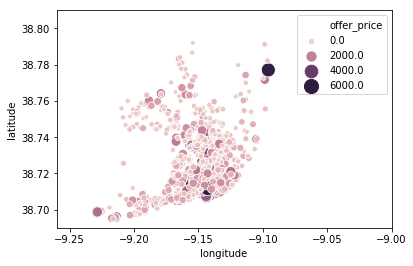

In [82]:
# Variable exploration

# Mapping the offers on a map trying to detect favourable neighbourhoods
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax = sns.scatterplot(x="longitude", y="latitude",hue="offer_price", size="offer_price",sizes=(20, 200), data=df)
ax = ax.set(xlim=(-9.26,-9), ylim=(38.69,38.81))

C:\Users\jojo\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


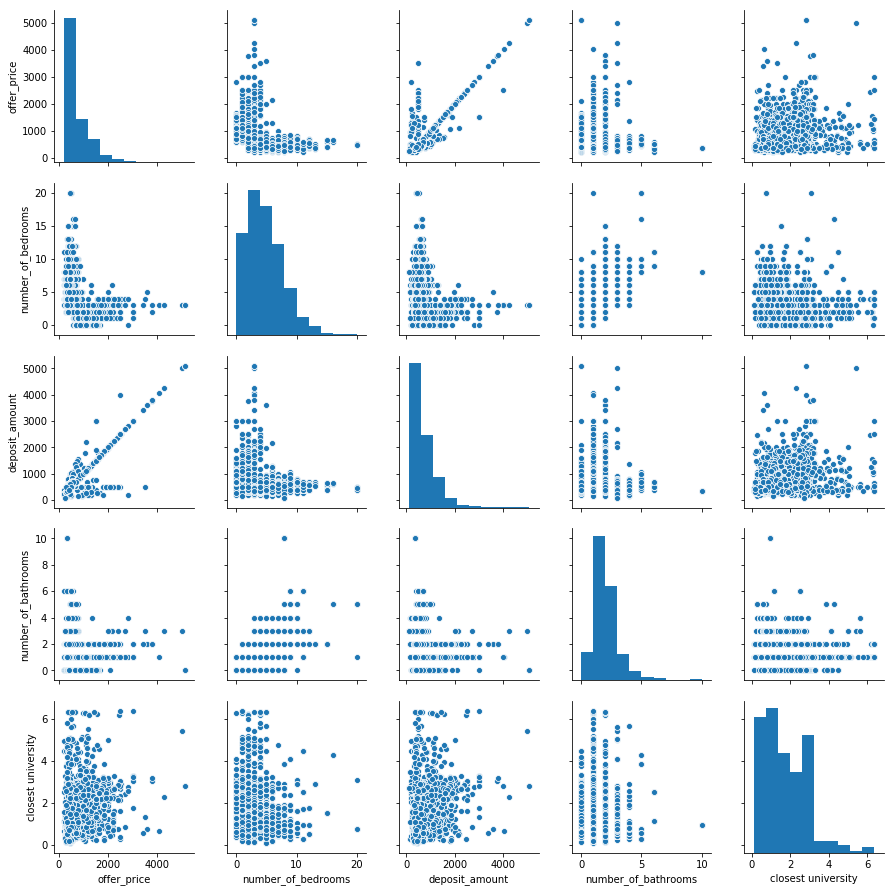

In [83]:
# Mapping the distribution and relation of selected variables  accom. Types: "{'private':1 | 'hostel':2 | 'residence':3,}"
df_pairpl = df[['offer_price','number_of_bedrooms','deposit_amount','number_of_bathrooms','closest university']].copy()
sns.pairplot(df_pairpl, size=2.5);

C:\Users\jojo\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


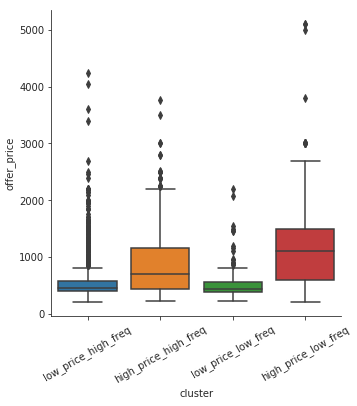

In [84]:
# Neighbourhood influence on prices
with sns.axes_style(style='ticks'):
    g = sns.factorplot("cluster", "offer_price", data=df, kind="box")
    g.set_xticklabels(rotation=30)

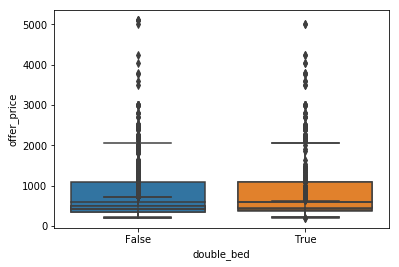

In [85]:
# Bed number and types influence on price  
sns.boxplot(x="single_beds", y="offer_price", data=df)
sns.boxplot(x="double_beds", y="offer_price", data=df)
sns.boxplot(x="double_bed", y="offer_price", data=df)

C:\Users\jojo\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


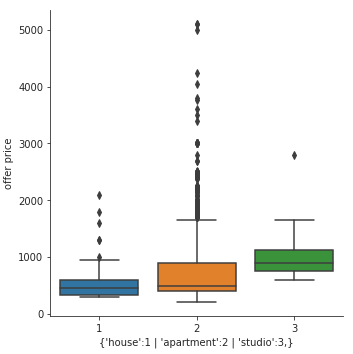

In [86]:
# Influence of housetype on price
with sns.axes_style(style='ticks'):
    g = sns.factorplot("property_type", "offer_price", data=df, kind="box")
    g.set_axis_labels("{'house':1 | 'apartment':2 | 'studio':3,}","offer price")

C:\Users\jojo\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


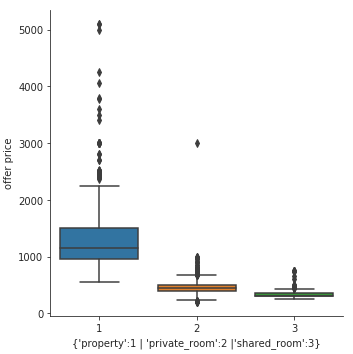

In [87]:
# Influence of propertytype on price
with sns.axes_style(style='ticks'):
    g = sns.factorplot("rental_type", "offer_price", data=df, kind="box")
    g.set_axis_labels("{'property':1 | 'private_room':2 |'shared_room':3}","offer price")

C:\Users\jojo\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


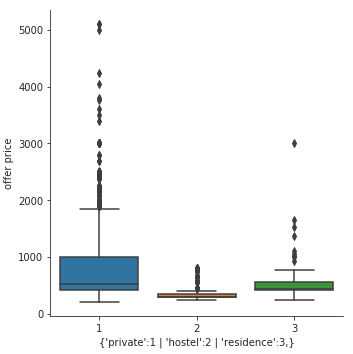

In [88]:
# Influence of accomodation type on price
with sns.axes_style(style='ticks'):
    g = sns.factorplot("accomodation_type", "offer_price", data=df, kind="box")
    g.set_axis_labels("{'private':1 | 'hostel':2 | 'residence':3,}","offer price")

In [89]:
# Encode cluster in order to show correlations
dict_cluster_type = {'high_price_high_freq':1,'high_price_low_freq':2,'low_price_high_freq':3,'low_price_low_freq':4}
df['cluster_encoded']= df['cluster'].replace(dict_cluster_type, inplace=False)

In [90]:
# Correlations 
#extracting relevant variables
df_corr = df[['offer_price','double_bed','closest university','property_type','cluster_encoded','number_of_bedrooms','number_of_bathrooms','deposit_amount','property_type']].copy()


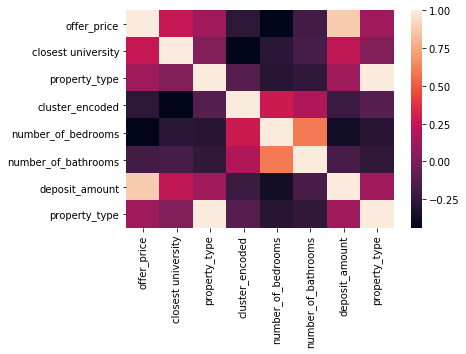

In [91]:
# Plotting the correlationsdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAbMAAAFJCAYAAAAR5MP4AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDIuMi4yLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvhp/UCwAAIABJREFUeJzt3Xm8rXPd//HX25TMUymFg4yJU2TIkEp+zUqZUhkquVMqv+5fSkW6Rb/cCnUnyVjKUEojKkNkOjiOg8Qt3bn1q7sISThnv39/XN/Nsqy999pn77Ov69rr/fS4Hntd82ct++zP+g7X9yvbREREtNkidQcQERExUUlmERHReklmERHReklmERHReklmERHReklmERHReklmERHReklmERHReklmERHReovVHUD09vhf7mrV0Cx/ev176g5h3D7zp5XrDmFcPrbUg3WHMG73/HW5ukMYt5OWnFd3CON21u/P10TOH8/fm8VXWXtC91pYkswiIgbd0Py6I5iwJLOIiEHnobojmLAks4iIQTeUZBYRES3n+e1rJ+yWZBYRMehSzRgREa2XDiAREdF6KZlFRETrpQNIRES0nadBySzDWUVEDLr58/pf+iDpNZJul3SnpEN67F9T0i8kzZF0qaTnT/QtJJlFRAy6ofn9L2OQtCjwFeC1wEbAnpI26jrsGOAM25sARwBHTfQtJJlFRAw6D/W/jG0L4E7bd9l+DPgOsHPXMRsBvyivL+mxf9ySzCIiBt3QUN+LpP0lzepY9u+62vOAP3Ss31O2dboJeGt5/RZgWUkTGvk7HUAiIgbdODqA2D4JOGmUQ3qNqt89Kv9HgS9L2ge4HPhvYELDkCSZRUQMusntmn8PsHrH+vOBezsPsH0vsAuApGWAt9p+YCI3bX01o6SDJN0m6VuSniHp55JmS9p9iu6/mqTzpuJeERELg4ce73vpw3XAupLWkrQEsAdwQecBklaRNJx/Pg6cMtH3MB1KZu8HXmv7d5K2Aha3PbPfkyUtZnuBirfl3HuBty3I+RERjTCJJTPb8yR9ALgQWBQ4xfYtko4AZtm+ANgBOEqSqaoZD5zofVtVMpN0sKS5ZfmwpBOBtYELJH0M+CYws5TM1pG0maTLJF0v6UJJzy3XuVTS5yRdBnxohHudJulESb+S9FtJbyjb95F0rqQfAhdJmiFpbtm3qKRjJN1cnp/4YNneM44e93yiYfXkM7492R9fRERvk9ubEds/sb2e7XVsH1m2fbokMmyfZ3vdcsx7bD860bfQmpKZpM2AfYEtqRoYrwHeAbwGeIXtv0i6Bvio7TdIWhw4E9jZ9v+Uascjgf3KJVew/fIxbjsDeDmwDnCJpBeU7VsDm9i+T9KMjuP3B9YCXly+naxU4jhhlDie0NmwOp5pzCMiJiQDDU+pbYHzbT8MIOl7wHajHL8+sDFwsSSoirt/7Nh/dh/3PMfVOC93SLoL2KBsv9j2fT2O3xE4cbjasiS7jceIIyKiXtNgOKs2JbNe3T3HOv4W21uPsP/hPq7RXToaXh/pXPU4Z6w4IiLqNQ0m52xTm9nlwJslLSVpaaoH7X41yvG3A8+StDWApMUlvXCc99xV0iKS1qFqm7t9jOMvAg6QtFi550qTFEdExMIzjoemm6o1JTPbN0g6Dbi2bDrZ9o2l6q7X8Y9JehtwvKTlqd7rl4BbxnHb24HLgFWBA2z/c6T7DccErAfMkfQ48HXbX56EOCIiFp4GJ6l+tSaZAdg+Fji2a9uMjteXApd2rM8Gtu9xnR36vOWVtj/Sde5pwGkd63dTtYlR2soOLkvnOT3jiIhoAjsdQCIiou1SMms/SYcCu3ZtPtf2PjWEExEx9dKbsf3KA31H1h1HRERtpkFvxoFPZhERAy/VjBER0XqpZoyIiNZLySwiIlovySwiIlov1YwREdF66c0YERGtl2rGWFj+9Pr31B3CuKz645PrDmHcTl1ttBmEmmevFV9Wdwjj9k8WrTuEcduQJeoOYeqlmjEiIlovJbOIiGi9JLOIiGi9+Rk1PyIi2i4ls4iIaL10AImIiNZLySwiIlrPrjuCCUsyi4gYdCmZRURE62U4q4iIaDsPpZoxIiLaLtWMERHReumaHxERrZdqxoiIaL157e8AskjdAURERM3s/pc+SHqNpNsl3SnpkBGO2U3SrZJukXTWRN9CSmYREYNuEjuASFoU+ArwauAe4DpJF9i+teOYdYGPA9vYvl/Ssyd638aVzCQdLumjC3DePpK+PMK+vy/A9WZImjve8ybr/IiIKTPk/pexbQHcafsu248B3wF27jrmvcBXbN8PYPvPE30LjUtmERExxTzU9yJpf0mzOpb9u672POAPHev3lG2d1gPWk3SlpKslvWaib6ERyUzSoaV+9efA+mXbzPIm50g6X9KKZfulkjYvr1eRdHfHpVaX9LNyrcNGuNe/SrquXPczY4S2mKTTy7HnSVqqXGMzSZdJul7ShZKe27H9JklXAQd23POFkq6VNLtca90RYnvil+Rbf763r88uImLCxlEys32S7c07lpO6rqYed+gu0i0GrAvsAOwJnCxphYm8hdqTmaTNgD2AFwO7AC8tu84APmZ7E+BmoGdy6rIFsBcwE9h1OOl13Gsnqg9wi3LMZpK2H+V66wMnlRgeBN4vaXHgBOBttjcDTgGOLMefChxke+uu6xwAHGd7JrA51TeVp+n8Jdnr2av18XYjIibO8+b3vfThHmD1jvXnA93fzu8BfmD7cdu/A26n+tu8wGpPZsB2wPm2/2H7QeACYGlgBduXlWNOB0ZLOsMutv1X248A3wO27dq/U1luBG4ANmD0D/APtq8sr79Zrrc+sDFwsaTZwCeB50tavivmMzuucxXwCUkfA9Ys8UVENMM4qhn7cB2wrqS1JC1BVVi5oOuY7wOvgKqGjara8a6JvIWm9GYczxN783gyCS85xnW61wUcZftrCxiXyzVu6S59lSJyz/dh+yxJ1wCvBy6U9B7bv+wzhoiIhWsSH5q2PU/SB4ALgUWBU2zfIukIYJbtC8q+nSTdCswH/tX2Xydy3yaUzC4H3iLpmZKWBd4IPAzcL2m7csw7geESz93AZuX127qu9WpJK0l6JvBm4Mqu/RcC+0laBkDS88boErqGpOGktSdwBVVx+FnD2yUtLumFtv8GPCBpuDS41/BFJK0N3GX7eKpvKJuMcs+IiKk1NNT/0gfbP7G9nu11bB9Ztn26JDJcOdj2RrZfZPs7E30LtZfMbN8g6WxgNvB74Fdl197AiaXTxV3AvmX7McA5kt4JdJdurqCq3nsBcJbtWV33ukjShsBVkgD+DrwDGKlb6G3A3pK+BtwBfNX2Y5LeBhxfqhYXA74E3FJiPEXSP6gS57DdgXdIehz4f8AR/X06ERFTYBoMZyVPgxlGp6N7tnxlq/7HrPrjk+sOYdyeudp2Yx/UID9f8WV1hzBu/2TRukMYt+uWbF/Mn/r9t3r1IOzbw5/are+/N0t/9pwJ3Wthqb1kFhER9eqzl2KjDXwyk7Qy8Iseu1410QbJiIhWmAbVjAOfzErCmll3HBERtUkyi4iI1svknBER0XopmUVERNt5XkpmERHRdpM4n1ldkswiIgZdqhkjIqL1kswiIqLtpsNIUElmERGDLiWzWFg+86eV6w5hXE5t2TiHAI/c+6uxD2qQ417y6bpDGLf2jXIIGzzW/j/s45XejBER0X4pmUVEROu1v2CWZBYRMeickllERLRekllERLReqhkjIqLtPC8ls4iIaLm0mUVERPulmjEiItpuGszNmWQWETHwkswiIqLtPK/uCCYuySwiYsClmjEiIlovySwiIlovySwiItrPqjuCCVuk7gD6JelkSRst4LkzJM1dgPN2kPSjBbnnZJwfETEVPNT/0lStSWa232P71rrjiIiYbobmqe+lH5JeI+l2SXdKOqTH/gMk3SxptqQrFrSg0qmRyUzS0pJ+LOkmSXMl7S7pUkmbl/1/l3Rk2X+1pFXL9nXK+nWSjpD09x7XXlTSF8oxcyS9b4xwlpN0vqRbJZ0oaZFynZ0kXSXpBknnSlqmbH+NpN9IugLYpeO+Ly//42ZLulHSsj1i21/SLEmzfvPQXQv+AUZEjIOtvpexSFoU+ArwWmAjYM8eyeos2y+yPRP4v8CxE30PjUxmwGuAe21vantj4Gdd+5cGrra9KXA58N6y/TjgONsvBe4d4drvBh4ox7wUeK+ktUaJZQvgfwMvAtYBdpG0CvBJYEfbLwFmAQdLWhL4OvBGYDvgOR3X+ShwYPmftx3wSPeNbJ9ke3Pbm2+w7NqjhBQRMXkmuZpxC+BO23fZfgz4DrDzU+5nP9ixujQw4cEhm5rMbgZ2lPR5SdvZfqBr/2PAcFvU9cCM8npr4Nzy+qwRrr0T8C5Js4FrgJWBdUeJ5dryP2U+8G1gW2Arqm8cV5br7A2sCWwA/M72HbYNfLPjOlcCx0o6CFjBng6PKUbEdOAh9b101iCVZf+uyz0P+EPH+j1l21NIOlDSf1KVzA6a6HtoZG9G27+VtBnwOuAoSRd1HfJ4SRYA8xnf+xDwQdsX9htOj3UBF9ve8ykXlmb2OL46yT5a0o+p3tPVkna0/ZtxxB0RsVB4HOUi2ycBJ41ySK+6yKfdwfZXgK9IejtVTdfe/UfxdI0smUlaDfiH7W8CxwAv6fPUq4G3ltd7jHDMhcC/SFq83Gs9SUuPcs0tJK1V2sp2B64o99lG0gvKNZaStB7wG2AtSeuUc59IdpLWsX2z7c9TVUtu0Od7iohYqMZTMuvDPcDqHevPZ+RmH6iqId88gfCBhiYzqvapa0sV3qHAv/V53oep2q6uBZ4LdFdPApwM3ArcULrrf43RS3ZXAUcDc4HfAefb/h9gH+DbkuZQJbcNbP8T2B/4cekA8vvO2Epnlpuo2st+2ud7iohYqIbmq++lD9cB65ZCwBJUBYsLOg+Q1Nm083rgjom+h6ZWM15IVYLqtEPH/mU6Xp8HnFdW/xvYyrYl7UFVAsL23cDG5fUQ8ImyjBXHpcClI+z7JVUHku7tP6NHqcv2B8e6X0REHfoscfV3LXuepA9Q/Q1fFDjF9i2SjgBm2b4A+ICkHYHHgfuZYBUjNDSZTcBmwJclCfgbsF/N8URENF4/Xe7Hdz3/BPhJ17ZPd7z+0KTekGmWzGz/Cth0vOdJehFwZtfmR21vOSmBRUQ0WJNH9ujXtEpmC8r2zcDMuuOIiKjD0DQYmzHJLCJiwA3Nb2pfwP4lmUVEDLjxPGfWVElmEREDbjJ7M9YlySwiYsClzSwiIlpvsrvm1yHJLCJiwKXNLCIiWm/+UHozRkREy6VkFgvNx5Z6cOyDGmSvFV9WdwjjdtxLPj32QQ3yoRuOqDuEcTtnk3Z9xgCf8911hzBuu07w/HQAiYiI1ksHkIiIaL2UzCIiovWmQZNZkllExKBLb8aIiGi9aTADTJJZRMSgM2kzi4iIlhuaBo1mSWYREQNuKCWziIhou/lJZhER0XZpM4uIiNZLb8aIiGi9JLOIiGi9VDNGRETrDbU/lyWZRUQMuunQm3GBBuSSdLikj052MF33WEHS+yfxeptLOn6yrjfCPX5dfs6Q9PaFea+IiMkyNI6lqZo8uuQKwKQlM9uzbB800etIGrE0a3t4hsoZQJJZRLTCkNT30lRjJjNJ75I0R9JNks7ssX+mpKvLMedLWrFsP0jSrWX7d8q2pSWdIuk6STdK2rlsf6GkayXNLsevCxwNrFO2faHrnjMkze1Y/6ikw8vrSyV9vlzvt5K2K9t3kPQjSYtIulvSCh3n3ylpVUnPkvTdEt91krYp+w+XdJKki4AzRogXSX8vlzwa2K7s/4ikX0ma2XG/KyVtMvb/noiIhc/jWJpq1DYzSS8EDgW2sf0XSSv1OOwM4IO2L5N0BHAY8GHgEGAt2492JI5DgV/a3q9su1bSz4EDgONsf0vSEsCi5fyNbc982h37eF+2t5D0uhLPjsM7bA9J+gHwFuBUSVsCd9v+k6SzgC/avkLSGsCFwIbl1M2AbW0/IumEHvF2OgT4qO03lM/xPmAf4MOS1gOeYXtOd9CS9gf2B/jsczZijxWfvwBvPSJifJpcfdivsUpmrwTOs/0XANv3de6UtDywgu3LyqbTge3L6znAtyS9A5hXtu0EHCJpNnApsCSwBnAV8AlJHwPWtP3IhN4VfK/8vJ6qyq/b2cDu5fUeZR2qpPflEt8FwHKSli37LuiIa7zxngu8QdLiwH7Aab0Osn2S7c1tb55EFhFTZZ7U99JUYyUzseAly9cDX6Eq0Vxf2poEvNX2zLKsYfs222cBbwIeAS6U9Moxrj2vK/Ylu/Y/Wn7Op3fp8yrgBZKeBbyZJ5PfIsDWHfE9z/ZDZd/DwyePN17b/wAuBnYGdgPOGuP9RURMmcmuZpT0Gkm3lyacQ3rsf4aks8v+ayTNmOh7GCuZ/QLYTdLKJYCnVDPafgC4f7hdCngncJmkRYDVbV8C/B+qzhzLUFXbfVCq0rukF5efawN32T6eqkS0CfAQsCy9/Ql4tqSVJT0DeMM43jO2DZwPHAvcZvuvZddFwAeGj+ts5+o0QrydesV+MnA8cF13CTciok5D6n8Zi6RFqQoyrwU2AvaUtFHXYe8G7rf9AuCLwOcn+h5GTWa2bwGOpEpQN1H98e+2N/AFSXOAmcARVG1I35R0M3AjVTvU34DPAosDc0oHjs+Wa+wOzC3VexsAZ5QEc6Wkud0dQGw/Xu5zDfAj4Dfjf+ucDbyDJ6sYAQ4CNi+dOm6lasvr5Wnxdu2fA8wrnWY+UmK+HngQOHUBYo2IWGgmuWv+FsCdtu+y/RjwHapaqU47UzVLAZwHvGq4kLOgxnxo2vbpHTcd3nZ4x+vZwFY9Tt22x7UeAd7XY/tRwFE9to/Yvb2Uip723JjtHTpe/4XSZmb7Uqp2uuF9s+CpTwqW43enS+f7HSPeZcrPx4FXde6TtBrVl4eLRnpPERF1GE9bUmdHteIk2yd1rD8P+EPH+j3All2XeeIY2/MkPQCsDPxlHKE8RUYAmQKS3kVVwj3Y9nToOBQR08h4hrMqieukUQ7pdbXufNnPMeOSZDYFbJ/B06siIyIaYd7Yh4zHPcDqHevPB+4d4Zh7SufA5YEJ9SVo8gggERExBaz+lz5cB6wraa3yHO4eVB3lOl1A1d8C4G1Uzx+nZBYREQtuMts+ShvYB6h6ry8KnGL7ljKoxizbFwDfAM6UdCdViWyPid43ySwiYsBNdkO+7Z8AP+na9umO1/8Edp3MeyaZRUQMuCaPudivJLOIiAGXyTkjIqL1Jrk3Yy2SzCIiBlyqGSMiovVSzRgREa03HYYlSjJrqHv+ulzdIYzLP582P2nztS3iczb59NgHNcxuc46oO4Rxu2OzT9UdwpRLNWNERLTevGmQzpLMIiIGXPtTWZJZRMTAS5tZRES0XnozRkRE6w1Ng4rGJLOIiAHX/lSWZBYRMfDSmzEiIlqv/aksySwiYuClN2NERLReOoBERETrtT+VJZlFRAy8VDNGRETrzZ8GZbMks4iIATcd2swWqTuAqSJphqS3L+C5O0h62WTHFBHRBB7H0lSNSmaSFsoUU5IWA2YAC5TMgB2AJLOImJaGcN9LU01ZMislo99IOl3SHEnnSVpK0t2SPi3pCmBXSTMlXV2OOV/SiuX8SyV9SdKvJc2VtEXZvrSkUyRdJ+lGSTuX7ftIOlfSD4GLgKOB7STNlvQRSb+SNLMjvislbdIrbuAA4CPl3O0k/U7S4mX/cuU9LD7eGCMimmBoHEtTTXWb2frAu21fKekU4P1l+z9tbwsgaQ7wQduXSToCOAz4cDluadsvk7Q9cAqwMXAo8Evb+0laAbhW0s/L8VsDm9i+T9IOwEdtv6Hc5z5gH+DDktYDnmF7TnfAtu+WdCLwd9vHlHMvBV4PfB/YA/iu7ccljStG2w9P+BONiJig6dABZKqrGf9g+8ry+pvAtuX12QCSlgdWsH1Z2X46sH3H+d8GsH05sFxJDDsBh0iaDVwKLAmsUY6/2PZ9I8RyLvCGUsLaDzhtHO/jZGDf8npf4NQJxPgESftLmiVp1g8fuWsc4URELDiP47+mmuqSWfcnMbzebwml1/kC3mr79s4dkrYc7bq2/yHpYmBnYDdg8z5joJQsZ0h6ObCo7bkLEmOP654EnARw6aq7Nve3JiKmlSZXH/Zrqktma0jaurzeE7iic6ftB4D7JW1XNr0TuKzjkN0BJG0LPFCOvxD4oEodn6QXj3Dvh4Blu7adDBwPXDdKCW6kc8+gKoWd2rV9IjFGREy5IbvvpammOpndBuxd2sVWAr7a45i9gS+UY2YCR3Tsu1/Sr4ETgXeXbZ8FFgfmSJpb1nuZA8yTdJOkjwDYvh54kKcnpG4/BN4y3AGkbPsWsCKlWnGSYoyImHLToWv+VFczDtk+oGvbjM4V27OBrUY4/7u2P951/CPA+7oPtH0aHe1gth8HXtV5jKTVqBL6RaMFbfu3QHdPx22B82z/bUFjjIhogiZ3ue9Xo54zm0qS3gVcAxxqe1xVxpJOoOrqnxJWRLTefNz3MhGSVpJ0saQ7ys8VexyzpqTrS03YLZK6C0A9TVnJzPbdVN3UF/T8HSYtmOp6Z1C1ez1B0r7Ah7oOvdL2gV3nfnAqYoyImApTWDI7BPiF7aMlHVLWP9Z1zB+Bl9l+VNIywFxJF9i+d7QLZ2zGDrZPZez2s4iIaWUKu9zvTDWiElSPXl1KVzKz/VjH6jPoswZxYKsZIyKiMp4RQDqfhy3L/uO41aq2/whQfj6710GSVi+dAP8AfH6sUhmkZBYRMfA8ji73nc/D9lJGYHpOj12HjuMefwA2KZ30vi/pPNt/Gu2cJLOIiAE3mW1mtnccaZ+kP0l6ru0/Snou8OcxrnWvpFuA7YDzRjs21YwREQNuqnozAhdQPUtM+fmD7gMkPV/SM8vrFYFtgFFHT4Iks4iIgTeFU8AcDbxa0h3Aq8s6kjaXdHI5ZkPgGkk3UY0AdYztm8e6cKoZIyIG3HjazCZ4n7/SNXhF2T4LeE95fTFPH6RiTElmEREDbjoMNJxkFhEx4Jo8tUu/kswiIgbc/PGN6NdISWYNddKS8+oOYVw2ZIm6Qxi3DR5r17fRz/nuukMYtzs2+1TdIYzbodcP3pCr02Gg4SSziIgBl2rGiIhovSZPutmvJLOIiAHX/lSWZBYRMfDSZhYREa2X3owREdF6KZlFRETrpTdjRES03lSNzbgwJZlFRAy4VDNGRETrpQNIRES0XtrMIiKi9TICSEREtF5KZhER0XopmUVEROulZBYREa03HXozLjJZF5J0uKSPLsB5K0h6/2TFMZUk7SPpy+M8525JqyysmCIixmvI7ntpqklLZhOwAjCuZKZKE2KPiGg9j+O/plrghCDpXZLmSLpJ0pld+y6VtHl5vYqku8vrF0q6VtLscu66wNHAOmXbF8px/yrpunLMZ8q2GZJuk/QfwA3A6iPEtZOkqyTdIOlcScuU7XdL+kzZfrOkDcr2ZSSdWrbNkfTWsn3Psm2upM93XH9fSb+VdBmwTcf2Z0n6bon7OknblO0rS7pI0o2SvgZolM90f0mzJM268+93j+d/R0TEArOH+l6aaoGSmaQXAocCr7S9KfChPk89ADjO9kxgc+Ae4BDgP23PtP2vknYC1gW2AGYCm0navpy/PnCG7Rfb/n2PuFYBPgnsaPslwCzg4I5D/lK2fxUYrhL9FPCA7RfZ3gT4paTVgM8DrywxvFTSmyU9F/gMVRJ7NbBRx7WPA75o+6XAW4GTy/bDgCtsvxi4AFhjpA/H9km2N7e9+QuWmTHa5xgRMWmGcN9LUy1oB5BXAufZ/guA7fukEQscna4CDpX0fOB7tu/ocd5OZbmxrC9Dldz+C/i97atHuf5WVAnmynLdJco9h32v/Lwe2KW83hHYY/gA2/eX5Hmp7f8BkPQtYDihdm4/G1iv4zobdbyf5SQtW87bpVz7x5LuHyX+iIgpN8gDDYvRZ9qex5OlviWHN9o+S9I1wOuBCyW9B7irx7WPsv21p2yUZgAP9xHXxbb3HGH/o+XnfJ58773ey2iZeaT3vQiwte1HnnKhKrm1/zclIqatQe7N+AtgN0krA0haqWv/3cBm5fXbhjdKWhu4y/bxVFVumwAPAct2nHshsF9HW9fzJD27z7iuBraR9IJy7lKS1hvjnIuAD3TEuCJwDfDy0t63KLAncFnZvkNpB1sc2HWU68wsLy8H9irbXgus2Od7iYiYEgPbm9H2LcCRwGWSbgKO7TrkGOBfJP0a6OyGvjswV9JsYAOq9q+/UlULzpX0BdsXAWcBV0m6GTiPpya70eL6H2Af4NuS5lAltw3GOO3fgBXL/W8CXmH7j8DHgUuAm4AbbP+gbD+cqury51QdUYYdBGxeOpHcStU+CFUb2/aSbqCqPv2vft5LRMRUmQ69GTUd6kqno7ev+ZZW/Y/ZkKXqDmHcNnis7gjG53O+u+4Qxm3nZ8yoO4RxO/T6z9YdwrgtvsrafXVaGMmqy2/Q99+bPz3wmwnda2HJCCAREQOuyb0U+9XaZFY6kjyja/M7bd9cRzwREW01f6j9HUBam8xsb1l3DBER08FUNTeVzoJnAzOoOgruZvtpjytJWoPqWd3VqXqDv84evZ49Q0JFRAy4KXxo+hDgF7bXpeoVf8gIx50BfMH2hlQDaPx5rAsnmUVEDDjbfS8TtDNwenl9OvDm7gMkbQQsZvviEtvfbf9jrAsnmUVEDLjxPGfWOYZsWfYfx61WLY84UX72eoZ4PeBvkr5XxrT9Qnned1StbTOLiIjJMZ7nx2yfBJw00n5JPwee02PXoX3eYjFgO+DFVM/lnk31/PA3xjopIiIG2GT2ZrS940j7JP1J0nNt/7EM3N6rLewe4Ebbd5Vzvk817u6oySzVjBERA24KRwC5ANi7vN4b+EGPY66jGpXpWWX9lcCtY104ySwiYsBNYQeQo4FXS7qDahqtowEkbS7p5BLLfKopun5RhjQU8PWxLpxqxoiIATdVz5mVsXhf1WP7LOA9HesXUw1E37eMzTjpWMVYAAAWE0lEQVRgJO1fGnBbo20xty1eSMxToW3xtk2qGQfPeLrRNkXbYm5bvJCYp0Lb4m2VJLOIiGi9JLOIiGi9JLPB08Y6+7bF3LZ4ITFPhbbF2yrpABIREa2XkllERLRekllERLRekllERLReklnEAJK0cd0xREymdACJRpK0DnCP7Ucl7UA1tM0Ztv9Wb2S9SVoaeMT2kKT1gA2An9p+vObQepJ0BbAEcBpwVlM/126SngmsYfv2umMZjaSVRttv+76pimVQpGQ2ACStKukbkn5a1jeS9O664xrDd4H5kl5ANfXDWsBZ9YY0qsuBJSU9j2o6+H2pEkUj2d4W2AtYHZgl6SxJr645rFFJeiMwG/hZWZ8p6YJ6oxrR9cCs8vN/gN8Cd5TX19cY17SVZDYYTgMuBFYr678FPlxbNP0Zsj0PeAvwJdsfAZ5bc0yjUZnafRfgBNtvATaqOaZR2b4D+CTwMeDlwPGSfiNpl3ojG9HhwBbA3wBszwZm1BjPiGyvZXttqn93b7S9iu2VgTcA36s3uukpyWwwrGL7HGAIoCSJ+fWGNKbHJe1JNefRj8q2xWuMZyyStDVVaefHZVtjZ6WQtImkLwK3Uc0X9UbbG5bXX6w1uJHNs/1A3UGM00tt/2R4xfZPqb44xCRLMhsMD0taGaqZ9SRtBTT9j8K+wNbAkbZ/J2kt4Js1xzSaDwMfB863fYuktYFLao5pNF8GbgA2tX2g7RsAbN9LVVprormS3g4sKmldSScAv647qDH8RdInJc2QtKakQ4G/1h3UdJQOIANA0kuAE4CNgbnAs4C32Z5Ta2BRG0kftv2lrm0fsn1cXTGNRdJSwKHATlQTNl4IfNb2P2sNbBSlI8hhwPZUXyYvB45IB5DJl2Q2ICQtBqxP9Ufg9gb3srsZRp6b3fa4Juxb2CT9kNHjfdMUhtM3STfYfknXthttv7iumPolaTnAth+qO5Z+SVrG9t/rjmM6a2ydfkweSQcC37J9S1lfUdKetv+j5tB6eUP5eWD5eWb5uRfwj6kPZ0zHlJ+7AM/hyarQPYG76whoNKUd8u3AWl09AZel4dVfkl4KnEIVK5IeAPaz3djegZJeBpwMLAOsIWlT4H22319vZNNPSmYDQNJs2zO7tjX6W7ikK21vM9a2ppB0ue3tx9pWN0lrUj3mcBRwSMeuh4A5pXNQI0maAxxo+1dlfVvgP5pWWu8k6RrgbcAFw//eJM21nYfWJ1lKZoNhEUly+eYiaVGqB2abbGlJ29q+Ap74hrt0zTGN5lmS1rZ9F0DpsPKsmmN6Gtu/B35P1bmmbR4aTmQAtq+Q1PiqRtt/kNS5qek9iVspyWwwXAicI+lEqvadAygPnjbYu4FTJC1PFfMDwH71hjSqjwCXSrqrrM8A3ldfOL1JusL2tiUJdFbLiKodarmaQuvHtZK+BnybKvbdqT7zlwAM98hsmD+UL2KWtARwENXjEDHJUs04ACQtQvWH9VVUf7QuAk623fhviKWxX214vkjSM6iGsQL4je1H64xnupE02qMOtv3KKQumT5JWAY4DduTJf3sfst3o9sk2SjKLRpK0KvA5YDXbr5W0EbC17W/UHFpPpdv4wcCatt8raV1gfds/GuPUWrRt7Euoqsfb8AUs6pFkNo1JOsf2biN1d294w/lPgVOBQ21vWh4tuNH2i2oOrSdJZ1ONufcu2xuXAXGv6u540xSSZgObU1WHXghcQJV8X1dnXKOR9DvgPOAU242uqisPdI/2yMZBUxjOQEib2fT2ofLzDaMe1Uyr2D5H0sehGoJLUpO/la9je/fS9R3bj6ir1b9hhspnOjz25QmSbqw7qDFsAuwBfKNUnZ8CfMf2g/WG1dOs8nMbqjE6zy7ru5KBhheKJLNpzPYfS8/Fb9jese54xqltQ3A9Vkpjw/GuAzS5zaxz7Ms3lm1NHvuS8pD014GvS9qeqiPIFyWdRzUSyJ21BtjB9ukAkvYBXjE8SEHphHVRjaFNW0lm05zt+ZL+IWn5NnSi6HAwVdXXOpKupAzBVW9IozqMqofo6pK+RfWNfJ9aIxrdvlS9Wtsy9uXwIyWvp4p9BvDvwLeA7YCfAOvVFtzIVqN6yHt4+KpleHL2iphEaTMbAJLOAbYCLgYeHt7e9Hr7tgzBNayUJLeiivdq23+pOaSeSlI43fY76o5lPMpjD5dQ1TT8umvf8U38fZa0L9XUNcM9MV8OHD5ccovJk2Q2ACTt3Wt7k/9BSVoSeD+wLVXV3a+AExs+qOwuPBnvFbbPrzmkEUkanmfrsbpj6VfnQ/Qd27axfWVdMfVD0nOALal+L661/f9qDmlaSjIbEOWBzQ2o/kHd3vQ/YqU0+RBPHetwRdu71hfVyCT9B/ACqnYcqB7o/U/bB458Vn3Kw8cvoarK7SytH1tbUGMYYXDkp21rGklvoho1H+Ay2z+sM57pKm1mA0DS64CvAf9JVQW2lqT3lYkCm2p925t2rF8i6abaohnby4GNO4YMOx24ud6QRnVvWRahDNzbVKomPX0Z1ZBhB3fsWg5YtJ6o+iPpaOClVG17AAdJepntj9cY1rSUZDYYjqXqUXUnPNHT7sdAk5PZjZK2sn01gKQtgSZXJ90OrEE17iHA6kBj54uz/RkASUvbfnis42u2BFXHicV4auJ9kGZ3CgJ4HTDT9hA88SXnRqqJXGMSJZkNhj93dVu+C/hzXcGMpuMB78WBd0n6r7K+JnBrnbH10jGf2fLAbZKuLetb0uBZkEtp5xu0YGoS25cBl0k6rQyU3JOkE2x/cApD69cKPNmbcfk6A5nOkswGwy2SfgKcQ/WHdlfgutJhAdvfqzO4Ln094C1pRdv3L+xg+nDM2Ic00peA/0XVZobtm8qzW401WiIrmjg90FFUtQyXUFXxb09KZQtFOoAMAEmnjrLbtps8Gn1PbWj47yTpKtuNmXZF0jW2t+yc107STV3tlK3S1N8JSc+lajcTcE16My4cKZkNANv7jrZf0sdtHzVV8UySJg8V1cuSdQfQJVOTTIEyXNgvbV9Q1leQ9Gbb3685tGlnkboDiEZoZHf3MbStSqFp8R4AHAg8D7gHmFnW26yJX3AO6xx5p8xKcFiN8UxbKZkFNPOPQCxcsr1X3UGMh6SNbc8d5ZDjpiyY/vUqMOTv7kKQkllA80oN/WhbAm5avL+WdJGkd0taoe5g+nSipGslvb9XzLZPqyGmscySdKykdSStLemLZNT8hSLJLKB5f2iBaviiMrYdkp5VBsMd9qqawhqRpDUl7VheP1NS5zNR76wprJ5srwt8EnghcIOkH0lq9FiNtrcF9qJ6hm+WpLMkvbrmsMbyQeAxqilgzgX+SfurcxspvRmnuTKo7EG2vzjKMZ+w/bkpDGtMkg6jmjxyfdvrSVoNONd2E7tfI+m9wP7ASrbXUTXT9Im2G5d0u0laherB+r1sN3pEDXjid/rNwPFUD04L+ETDHjGJKZaS2TRXppnfeYxjGpXIircAb6KMG2j7Xpo97NKBVM85PQhg+w7g2bVGNApJy0nau8zo/Wvgj8AWNYc1KkmblGq624BXUg2UvGF5PeKXtTpJWk/SSaVK95fDS91xTUdpiBwMV0r6MlVVR+egsjfUF9KYHrNtScNjHS5dd0BjeNT2YyqTS5fpa5pc7XET8H3gCNtX1R1Mn75MNTnnJ2w/MrzR9r2SPllfWKM6FzgROBlo8kzprZdkNhheVn4e0bHNVN9om+qcMrL7CqUKbz+qP2RNdZmkTwDPLO047weaPDr62m5fG8P3bJ/ZuUHSh2wf1729QebZ/mrdQQyCtJlFY5WksBNVm8iFti+uOaQRSVoEeDcd8QInNy1hSPqS7Q93jCn5FLbfVENYfRlhCpgnRjBpIkmHU42Dej7w6PB22/eNdE4smCSzASBpVeBzwGq2XytpI2Br29+oObSYYpI2s329pJf32l8G9W0USXsCbwe2Ay7v2LUsMN/2jrUE1gdJv+ux2bbXnvJgprkkswFQGvlPBQ61vWlpz7nR9otqDu1pJD1E77YmUf0RWG6KQxpVxyj/PdneZArDmZYkrQmsRTVo7yEdux4C5tieV0tg0ShpMxsMq9g+R9LHAWzPk9TIxmjbTe6x2Etfo/w3jaRtgMOpptZZjCe/LDSuxGD795LuAR5uYslxNJKWAg4G1rC9f3lkY33bP6o5tGknyWwwPCxpZUoJQtJWwAOjn1I/SS8BtqWK+wrbN9Yc0tP0MS1JU30D+AjVaBSN/GLTyfZ8Sf+QtHznWIctcCrVZzzcCeseqh6OSWaTLMlsMBxMNW/VOpKuBJ5Fw2folfRpqgGQhx+EPU3Subb/rcawRjRC9egDwCzgf9u+a+qjGtUDtps803gv/wRulnQxT33E5KD6QhrTOrZ3L+1+2H5Ew89vxKRKMpvGJO1q+1zgfuDlwPpU1Um323681uDGtifwYtv/BJB0NHAD0MhkRjWCxr3AWVSf8R7Ac4DbgVOAHWqLrLdLJH2B6stCZy+7Jj97+OOytMljkp7Jk7Ui69DxecfkSQeQaWy4K3NTJy0cTem0smeZMoMysOw3bTeyjWp4ssuubVfb3qqJk16WmY+72XaTnz2kJIY1bN9edyz9KI+XfBLYCLiIapSYfWxfWmdc01FKZtPbfeWP1lqSLuje2cRniiSdQPUt9lHgllKlZODVwBV1xjaGIUm7AeeV9c5q3MZ9Y7T9irpjGC9JbwSOAZag+p2eSTWCSeN+j4fZvljSDcBWVCX2D9n+y/B+SS+0fUttAU4jKZlNY2UG4ZcAZwLv6d7fxJ5hkvYebb/t06cqlvGQtDbVfFpbUyWvq6k6WPw3sJntRiXi0ib5NLaP6LW9CSRdTzVqzaXDD0pLurmJj5j0q421Jk2Vktn09g3b75T09SYmrl6amqzGUjp4vHGE3Y1KZMXDHa+XpHrE4LaaYunXPNsPdPWfaPu38XQGmSRJZtPbZuWB070kfZ2ufzhNHlKnjJzQa7ilxj0HBdV8a8B7gRl0/LuyvV9dMY3G9r93rks6hqrHa5PNlfR2YNHyvNZBVCP+t1nbk3FjJJlNbycCPwPW5qmz24rqH1EjE0OxecfrJam66a9UUyz9+AHwK+DntOC5rR6Wotm/D1BNdHkoVXvqt6nGv/xsrRFFY6TNbABI+ipVYtu+bLrc9k01hrRAJF1RZhtuHEmzbc+sO45+dQ3DtSjVs4dH2P5yfVH1R9JyVD0vH6o7ltGU58meb/sPoxxzte2tpjCsaSsls8HwG+CbVM8UCTiztKOdUG9YIyujfwxbhKqk1uShrn4k6XW2f1J3IH3qfMRhHvCnpo9xKOmlVM/sLVvWHwD2s339qCfWpMzH931gs1GOSSKbJCmZDQBJc6hGyX+4rC8NXNXkQXC7noOaB9wNHNPU54vKCCBLU1WBPU5DB0Zus/J7fKDtX5X1bYH/aPjv8VeA02xfV3cs011KZoNBPLUdZz4N70XVtuegWjhAchs9NJzIAGxfUb5ENNkrgAMk3U3Vg3T4S05jE3BbJZkNhlOBaySdX9bfTDXQbGNJWh44jCfb+S6jatNp1CCzkjaw/ZuuatEnNHx4qLa5tsw+/m2q9r7dgUuHP/uGftavrTuAQZFqxgHRMQK9qDqANG4E+k6SvgvMBYafO3snsKntXeqL6ukknVSm9uisFn3iH1VTh4eS9HnbHxtrW5OMMATXsMYOxVWqQ9e1fWp5hGMZ270m7YwJSDKLRurVO7DJPQbLUFY/s/2gpE9Rjbzy2YaWFnqOPCFpTqq/Jpekw6g6L61vez1JqwHn2t6m5tCmnUXqDiBiBI+Ub7TAE5NJPlJjPGP5ZElk21KNI3ka8NV6Q3o6Sf9SuuWvL2lOx/I7YE7d8Y1G0vKSjpU0qyz/Xqqjm+wtwJsoI67Yvpdm98ptrbSZRVMdAJzR8cfqfmDUcRtrNtzB5vXAibZ/IOnwGuMZyVnAT4GjgEM6tj/U5BFhilOoqp53K+vvpGoPblTVc5fHShf94Slglq47oOkq1YzRKJIO7lyl6u4O1Tdb2z526qMam6QfUQ0qvCPVc0WPANc2beqXYWVerXtsPyppB2AT4IzhKXeaqG1VzwCSPgqsS1VaPwrYD/i27eNrDWwaSjVjNM2yZdmcqnS2HLA88D6qOaGaajeq4ZVeUxLCSsC/1hvSqL4LzJf0AqqerWtRldqarG1Vz9g+hmpaoO9STY776SSyhSMls2gkSRcBbx0eskjSslQN56+pN7LpoWPi1v8DPGL7BEk3Dk+t0kSSNgXOoPpyA6Xq2XZj2/ra2Gu0rVIyi6ZaA3isY/0xqhHpY3I8LmlP4F3Aj8q2xWuMZ1SSFqHqEbgpVZXoJrZf3OREVry6x7Y8e7YQpANINNWZVA/Jnk/13NZbePKZs5i4famqcY+0/TtJa1GN39lItockfQA4x/aDdcczFkn/ArwfWLsMwzVsWeDKeqKa3lLNGI1VHvTerqw2/kHvtpH0TGCNpo532a08v/cIcDYdk4s2sRdm6YW7Iu3sNdpKSWYRA0jSG4FjgCVsryVpJtVwYW+qObQRtW3CVmhnr9G2SptZxGA6HNgC+BuA7dlUPRqbbCPgK8BNwGzgBOCFtUY0tjb2Gm2lJLOIwTSvx6DNTa+mOR3YEDieKpFtSPPbUYfKPHG7AF+y/RHguTXHNC2lA0jEYJor6e3AopLWBQ4Cfl1zTGMZ7s047BJJTZ8xvbPX6BvLtsb2Gm2zlMwiBtMHqaroHqWaUuVB4MO1RjS2GyU9MTOzpC1pfs/AfYGtaUmv0TZLB5CIASdpUWDppnd5l3Qb1Sga/1U2rQHcBgyRCS8HXpJZxACSdBbVc2bzgeupRtU41vYXag1sFJLWHG2/7d9PVSz9amMPzLZKm1nEYNqoTFmzF/AT4GNUSa2xyayJyaoPm3e8XhLYlWrczphkaTOLGEyLS1oceDPwA9uP0/zejK1j+68dy3/b/hLQyBmx2y4ls4jB9DXgbqpnti4vVXiNbjNrozKKzbBFqEpqmZxzIUibWUQAIGmx8kxUTBJJl3SszqP6AnFMW4YQa5Mks4gBVMYOPAzYvmy6jGo4q+4HqSNaIcksYgBJ+i4wlydH0HgnsKntXeqLavromjH9aZo6Y3qbpc0sYjCtY/utHeufkTS7tmimn9HaxVKCWAiSzCIG0yOStrV9BYCkbaimV4lJYPszAJJOBz40PEq+pBWBf68ztukqySxiMP0LcHppOxNwH7BPrRFNT5t0Tvdi+35JL64zoOkqySxiAJUpXzaVtFxZT7f8hWMRSSvavh9A0krk7+5CkQ81YoCM1DFBEpCOCQvBvwO/lnQeVVvZbsCR9YY0PSWZRQyWPLA7hWyfIWkW1agfAnaxfWvNYU1L6ZofERGtl7EZIwaQpNMlrdCxvqKkU+qMKWIikswiBtPTetkB6WUXrZVkFjGYFinPPAHpZRftl1/eiMGUXnYxraQDSMSAkrQRT/ay+0V62UWbJZlFRETrpc0sIiJaL8ksIiJaL8ksIiJaL8ksIiJa7/8DlVmCYub/0twAAAAASUVORK5CYII=
corr = df_corr.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

### [7] Regression Analyses
As a base for our prediction model we performed several regression analyses and compared their performance

In [92]:
# show null values
null_values = df.isnull().sum()
null_values

commission_rate                 0
deposit_amount                  0
contract_type                   0
internet_included               0
offer_id                        0
offer_price                     0
cancellation_policy             0
max_guests                      0
minimum_no_night                0
creation_date                   0
landlord_prev_confirmed         0
neighborhood_id                14
neighborhood                   14
property_id                     0
latitude                        0
longitude                       0
accomodation_type               0
number_of_bathrooms             0
number_of_bedrooms              0
property_type                   0
property_verified               0
kitchen_window                503
pets_allowed                  199
smoking_allowed               229
overnight_guests_allowed      246
bedroom_balcony               517
single_beds                   228
double_beds                   228
kitchen_freezer               550
kitchen_fridge

In [93]:
# Impute null values with mean
df['bathrooms_per_person'].fillna((df['bathrooms_per_person'].mean()), inplace=True)

In [94]:
# Drop columns that either 
# a) depend directly on the offer price (commission_amount, deposit_amount)
# or are redundant (e.g. single beds, double beds, closest uni..)
df.drop(columns = ['commission_amount','deposit_amount','single_beds','double_beds','subways within 0.5 km','closest university','closest attraction'], inplace=True)

In [95]:
# fill NaN booleans with median and convert to bool
for i in ['kitchen_window','pets_allowed','smoking_allowed','overnight_guests_allowed','kitchen_fridge','kitchen_stove','landlord_response_rate','double_bed','bedroom_balcony','kitchen_freezer','kitchen_microwave','kitchen_oven','bedroom_window','cleaning','kitchen_washing-machine']:
    df[i].fillna((df[i].median()), inplace=True)
    df[i] = df[i].astype(bool)

In [96]:
# Check data types
df.dtypes

commission_rate                      float64
contract_type                          int64
internet_included                       bool
offer_id                               int64
offer_price                          float64
cancellation_policy                    int64
max_guests                             int64
minimum_no_night                       int64
creation_date                 datetime64[ns]
landlord_prev_confirmed                int64
neighborhood_id                      float64
neighborhood                          object
property_id                            int64
latitude                             float64
longitude                            float64
accomodation_type                      int64
number_of_bathrooms                    int64
number_of_bedrooms                     int64
property_type                          int64
property_verified                       bool
kitchen_window                          bool
pets_allowed                            bool
smoking_al

In [97]:
# Check which variables are correlated with the price
# In order to give less weight to outliers, we use the log price moving forward
corr_matrix = df.corr().abs()
corr_matrix["log_offer_price"].sort_values(ascending=False)

log_offer_price               1.000000
offer_price                   0.936641
rental_type                   0.823775
max_guests                    0.692941
number_of_bedrooms            0.512832
bathrooms_per_person          0.486764
double_bed                    0.425574
property_id                   0.346072
cluster_encoded               0.309151
attractions within 0.5 km     0.295823
latitude                      0.290377
offer_id                      0.284192
contract_type                 0.278736
landlord_prev_confirmed       0.273048
number_of_bathrooms           0.230478
minimum_no_night              0.206351
property_type                 0.191286
accomodation_type             0.190712
bedroom_balcony               0.138185
bedroom_window                0.115503
property_verified             0.111647
commission_rate               0.109613
universities within 0.5 km    0.106134
cancellation_policy           0.103834
longitude                     0.086250
pets_allowed             

In [98]:
# Choose variables to include in the regression model
#df_regress=df[['rental_type','bathrooms_per_person','number_of_bedrooms','double_bed','cluster','closest subway','cleaning','internet_included','all_expenses_included','bedroom_window','bedroom_balcony']]
df_regress=df[['rental_type','bathrooms_per_person','number_of_bedrooms','double_bed','cluster','internet_included','bedroom_window']]

In [99]:
# Create dummies for categorical values
n = pd.get_dummies(df['rental_type'],prefix='rental_type')
df_regress = pd.concat([df_regress, n], axis=1)
m = pd.get_dummies(df['cluster'],prefix='neighborhood_type')
df_regress = pd.concat([df_regress, m], axis=1)

# Drop the non-encoded columns
df_regress.drop(columns = ['rental_type','cluster'],inplace=True)

In [100]:
# Observe regression data frame
df_regress.head()

,bathrooms_per_person,number_of_bedrooms,double_bed,internet_included,bedroom_window,rental_type_1,rental_type_2,rental_type_3,neighborhood_type_high_price_high_freq,neighborhood_type_high_price_low_freq,neighborhood_type_low_price_high_freq,neighborhood_type_low_price_low_freq
0,0.14,7,True,True,True,0,1,0,0,0,1,0
1,0.00,4,False,False,True,0,1,0,0,0,1,0
3,0.25,4,False,True,False,0,1,0,1,0,0,0
5,0.25,4,True,True,True,0,1,0,0,0,1,0
7,0.67,3,False,True,True,0,1,0,0,0,1,0


#### [7.1] Multi-variate regression

In [101]:
# Import relevant packages
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [102]:
#select the variable we are trying to predict
df_y = df[['log_offer_price']].copy()

In [103]:
# Select the regression model
reg = linear_model.LinearRegression()

In [104]:
# Create a training and a testing set
x_train, x_test, y_train, y_test = train_test_split(df_regress,df_y,test_size = 0.2, random_state = 4)

In [105]:
#regression analysis
reg.fit(x_train,y_train)
reg.coef_
reg.intercept_

array([5.95131147])

In [106]:
# Save predicted prices to the dataframe
df['predicted_price_multivariate']=np.exp(reg.predict(df_regress))

In [107]:
# Observe the difference in predicted and actual price for a subjective evaluation of the model
test = df[['predicted_price_multivariate','offer_price']]
y_pred = reg.predict(df_regress)
reg.score(x_test,y_test)

0.7753072258794313

#### [7.2] Random forest regressor

In [108]:
# Import relevant packages
from sklearn.ensemble import RandomForestRegressor

In [109]:
# Set regression model
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(x_train,y_train)
forest_reg.score(x_test,y_test)

C:\Users\jojo\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\jojo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.8306208223095164

In [110]:
# Save estimated prices to dataframe
df['predicted_price_randomforest']=np.exp(forest_reg.predict(df_regress))

In [111]:
# Observe difference to actual price for a subjective evaluation of the model
test = df[['offer_price','predicted_price_randomforest']]

#### [7.3] Gradient Boost Regressor

In [112]:
# Import relevant packages
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

In [113]:
# Set the model
model = ensemble.GradientBoostingRegressor(n_estimators=800,max_depth=5,min_samples_split=2,learning_rate=0.1,loss='ls')
model.fit(x_train,y_train)
model.score(x_test,y_test)

C:\Users\jojo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8107513710557303

In [114]:
# Save estimated prices to dataframe
df['predicted_price_gradientboost']=np.exp(model.predict(df_regress))

In [115]:
# Observe difference to actual price for a subjective evaluation of the model
df[['predicted_price_gradientboost','offer_price']]

,predicted_price_gradientboost,offer_price
0,446.293529,460.0
1,214.528508,215.0
3,349.976261,350.0
5,434.912632,500.0
7,425.394087,350.0
8,351.982436,414.0
9,1873.840164,3000.0
10,456.898116,454.0
11,440.257722,340.0
12,2075.623721,2100.0


#### [7.4] XG Boost Regressor

In [116]:
# Import relevant package
import xgboost

In [117]:
# Set the model specifications
best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [ ]:
# Train and test the model
best_xgb_model.fit(x_train,y_train)
best_xgb_model.score(x_test,y_test)

In [ ]:
# Save predicted price to data frame
df['predicted_price_gxboost']=np.exp(best_xgb_model.predict(df_regress))

In [ ]:
# Comparison between real price and all predicted prices
Results = df[['offer_id','offer_price','predicted_price_multivariate','predicted_price_randomforest','predicted_price_gradientboost','predicted_price_gxboost']]

In [ ]:
#Most_relevant_features
feature_labels = np.array(['bathrooms_per_person', 'number_of_bedrooms', 'double_bed',
       'internet_included', 'bedroom_window',
       'rental_type_1', 'rental_type_2', 'rental_type_3',
       'neighborhood_type_high_price_high_freq',
       'neighborhood_type_high_price_low_freq',
       'neighborhood_type_low_price_high_freq',
       'neighborhood_type_low_price_low_freq'])
importance = best_xgb_model.feature_importances_
feature_indexes_by_importance = importance.argsort()
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

In [ ]:
import matplotlib.pyplot as plt

# Plot the feature importance
plt.bar(np.arange(len(feature_labels)),importance, align='center',alpha=0.5)
plt.xticks(np.arange(len(feature_labels)),feature_labels,rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature importance')
 
plt.show()

### [8] Price Prediction and Visualization
Based on our regression model, we built a prototype user-interface in order to predict the price of a housing offer based on the user's input variables

In [ ]:
# Import relevant packages
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from sklearn.linear_model import LogisticRegression
from sklearn.datasets.samples_generator import make_blobs

In [ ]:
# Export neighborhoods to a list for user selection
neighborhoods = df['neighborhood'].unique().tolist()

In [ ]:
# Create widget to choose housing area
Area = widgets.Dropdown(
    options=neighborhoods,
    description='Area:',
)

# Create widget to choose number of bedrooms
Bedrooms = widgets.IntSlider(
    value=1,
    min=1,
    max=15,
    step=1,
    description='Bedrooms:',
)

# Create widget to choose number of bathrooms
Bathrooms = widgets.IntSlider(
    value=1,
    min=1,
    max=5,
    step=1,
    description='Bathrooms:',
)

# Create widget to choose double-bed
Double_Bed = widgets.Checkbox(value=False,description ='Double bed',disabled=False)
# Create widget to choose bedroom window
Bedroom_window = widgets.Checkbox(value=False,description ='Bedroom window',disabled=False)
# Create widget to choose included internet
Internet_included = widgets.Checkbox(value=False,description ='Internet included',disabled=False)

# Create widget to choose rental type
Rental_type = widgets.ToggleButtons(
    description='Rental Type:',
    options=['Private Room', 'Shared Room', 'Appartment'],
)

# Define function that takes the widget variables as input and outputs the regression result
def f(Area,Bedrooms,Bathrooms,Double_Bed,Bedroom_window,Internet_included,Rental_type):
    # Define variables
    double_bed = Double_Bed
    bathrooms = Bathrooms
    bedrooms = Bedrooms
    neighborhood = Area
    window = Bedroom_window
    internet = Internet_included
    bathrooms_per_person = bathrooms/bedrooms
    
    # Define input array for the prediction. We set everything to false to take care of the one-hot encoded variables and will adjust values accordingly
    values = [False,False,False,False,False,False,False,False,False,False,False,False]
    
    # Change the initial values based on the input variables
    values[0] = bathrooms_per_person
    values[1] = bedrooms
    values[2] = double_bed
    values[3] = internet
    values[4] = window
    
    # Change input for the one-hot-encoded variables
    if Rental_type == 'Appartment':
        values[5] = True
    elif Rental_type == 'Private Room':
        values[6] = True
    else:
        values[7] = True
        
    if neighborhood in low_price_low_freq.index:
        values[11] = True
    elif neighborhood in low_price_high_freq.index:
        values[10] = True
    elif neighborhood in high_price_low_freq.index:
        values[9] = True
    else:
        values[8] = True
   
    # Create new variables
    Xnew =  pd.DataFrame([values], columns=df_regress.columns)
    # Predict price based on our regression model
    ynew = best_xgb_model.predict(Xnew)
    # Print the result
    print("The predicted price for your room search is:\n%s €" % (round(np.exp(ynew[0]),0)))

# Define interactive output from the widgets to the output function
out = widgets.interactive_output(f,{'Area':Area,'Bedrooms':Bedrooms,'Bathrooms':Bathrooms,'Double_Bed':Double_Bed,'Bedroom_window':Bedroom_window,'Internet_included':Internet_included,'Rental_type':Rental_type})

# Define layout: widgets will be ordered horizontally and the output to the right
widgets.HBox([widgets.VBox([Area, Bedrooms, Bathrooms,Double_Bed,Bedroom_window,Internet_included, Rental_type]), out])
